# Load Library

In [1]:
import numpy as np 
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.weightstats import ztest 
from statsmodels.tsa.stattools import adfuller
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import warnings 
warnings.filterwarnings(action = 'ignore') 
pd.options.display.max_columns = 999 

# Read Dataset

In [2]:
train = pd.read_csv('../dacon power use/dataset/train.csv', encoding= 'CP949')
train

num      date_time  전력사용량(kWh)  기온(°C)  풍속(m/s)  습도(%)  강수량(mm)  \
0         1  2020-06-01 00    8179.056    17.6      2.5   92.0      0.8   
1         1  2020-06-01 01    8135.640    17.7      2.9   91.0      0.3   
2         1  2020-06-01 02    8107.128    17.5      3.2   91.0      0.0   
3         1  2020-06-01 03    8048.808    17.1      3.2   91.0      0.0   
4         1  2020-06-01 04    8043.624    17.0      3.3   92.0      0.0   
...     ...            ...         ...     ...      ...    ...      ...   
122395   60  2020-08-24 19    4114.368    27.8      2.3   68.0      0.0   
122396   60  2020-08-24 20    3975.696    27.3      1.2   71.0      0.0   
122397   60  2020-08-24 21    3572.208    27.3      1.8   71.0      0.0   
122398   60  2020-08-24 22    3299.184    27.1      1.8   74.0      0.0   
122399   60  2020-08-24 23    3204.576    27.1      2.6   75.0      0.0   

        일조(hr)  비전기냉방설비운영  태양광보유  
0          0.0        0.0    0.0  
1          0.0        0.0    0.0  
2          0.0        0.0    0.0  
3          0.0        0.0    0.0  
4          0.0        0.0    0.0  
...        ...        ...    ...  
122395     0.7        1.0    1.0  
122396     0.0        1.0    1.0  
122397     0.0        1.0    1.0  
122398     0.0        1.0    1.0  
122399     0.0        1.0    1.0  

[122400 rows x 10 columns]

In [3]:
test = pd.read_csv('../dacon power use/dataset/test.csv', encoding = 'CP949')
test

num      date_time  기온(°C)  풍속(m/s)  습도(%)  강수량(mm, 6시간)  일조(hr, 3시간)  \
0        1  2020-08-25 00    27.8      1.5   74.0           0.0          0.0   
1        1  2020-08-25 01     NaN      NaN    NaN           NaN          NaN   
2        1  2020-08-25 02     NaN      NaN    NaN           NaN          NaN   
3        1  2020-08-25 03    27.3      1.1   78.0           NaN          0.0   
4        1  2020-08-25 04     NaN      NaN    NaN           NaN          NaN   
...    ...            ...     ...      ...    ...           ...          ...   
10075   60  2020-08-31 19     NaN      NaN    NaN           NaN          NaN   
10076   60  2020-08-31 20     NaN      NaN    NaN           NaN          NaN   
10077   60  2020-08-31 21    27.9      4.1   68.0           NaN          0.0   
10078   60  2020-08-31 22     NaN      NaN    NaN           NaN          NaN   
10079   60  2020-08-31 23     NaN      NaN    NaN           NaN          NaN   

       비전기냉방설비운영  태양광보유  
0            NaN    NaN  
1            NaN    NaN  
2            NaN    NaN  
3            NaN    NaN  
4            NaN    NaN  
...          ...    ...  
10075        NaN    NaN  
10076        NaN    NaN  
10077        1.0    1.0  
10078        NaN    NaN  
10079        NaN    NaN  

[10080 rows x 9 columns]

In [4]:
# 컬럼명 변경 
train.columns = ['num', 'date_time', '전력사용량', '기온', '풍속', '습도', '강수량', '일조', '비전기냉방설비운영', '태양광보유']
test.columns = ['num', 'date_time', '기온', '풍속', '습도', '강수량', '일조', '비전기냉방설비운영', '태양광보유']

# Filling Missing Values

## test 데이터셋의 비전기냉방설비운영, 태양광보유 결측치 처리

건물별 비전기냉방설비운영, 태양광보유 여부를 통해 test 데이터셋의 비전기냉방설비운영, 태양광보유 결측치를 처리한다.

In [5]:
mapping = {}

for i in train['num'].unique():
    mapping[i] = train.loc[train['num'] == i, '비전기냉방설비운영'].unique()[0], train.loc[train['num'] == i, '태양광보유'].unique()[0]
    
test['비전기냉방설비운영'] = test['num'].apply(lambda x: mapping[x][0])
test['태양광보유'] = test['num'].apply(lambda x: mapping[x][1])
test

num      date_time    기온   풍속    습도  강수량   일조  비전기냉방설비운영  태양광보유
0        1  2020-08-25 00  27.8  1.5  74.0  0.0  0.0        0.0    0.0
1        1  2020-08-25 01   NaN  NaN   NaN  NaN  NaN        0.0    0.0
2        1  2020-08-25 02   NaN  NaN   NaN  NaN  NaN        0.0    0.0
3        1  2020-08-25 03  27.3  1.1  78.0  NaN  0.0        0.0    0.0
4        1  2020-08-25 04   NaN  NaN   NaN  NaN  NaN        0.0    0.0
...    ...            ...   ...  ...   ...  ...  ...        ...    ...
10075   60  2020-08-31 19   NaN  NaN   NaN  NaN  NaN        1.0    1.0
10076   60  2020-08-31 20   NaN  NaN   NaN  NaN  NaN        1.0    1.0
10077   60  2020-08-31 21  27.9  4.1  68.0  NaN  0.0        1.0    1.0
10078   60  2020-08-31 22   NaN  NaN   NaN  NaN  NaN        1.0    1.0
10079   60  2020-08-31 23   NaN  NaN   NaN  NaN  NaN        1.0    1.0

[10080 rows x 9 columns]

## test 데이터셋의 기상정보 결측치 보간 

기상정보의 결측치에 대해서는 보간법을 사용한다 

In [6]:
test = test.interpolate(method='values')
test

num      date_time         기온        풍속         습도  강수량        일조  \
0        1  2020-08-25 00  27.800000  1.500000  74.000000  0.0  0.000000   
1        1  2020-08-25 01  27.633333  1.366667  75.333333  0.0  0.000000   
2        1  2020-08-25 02  27.466667  1.233333  76.666667  0.0  0.000000   
3        1  2020-08-25 03  27.300000  1.100000  78.000000  0.0  0.000000   
4        1  2020-08-25 04  26.900000  1.166667  79.666667  0.0  0.000000   
...    ...            ...        ...       ...        ...  ...       ...   
10075   60  2020-08-31 19  28.633333  3.566667  66.000000  0.0  0.533333   
10076   60  2020-08-31 20  28.266667  3.833333  67.000000  0.0  0.266667   
10077   60  2020-08-31 21  27.900000  4.100000  68.000000  0.0  0.000000   
10078   60  2020-08-31 22  27.900000  4.100000  68.000000  0.0  0.000000   
10079   60  2020-08-31 23  27.900000  4.100000  68.000000  0.0  0.000000   

       비전기냉방설비운영  태양광보유  
0            0.0    0.0  
1            0.0    0.0  
2            0.0    0.0  
3            0.0    0.0  
4            0.0    0.0  
...          ...    ...  
10075        1.0    1.0  
10076        1.0    1.0  
10077        1.0    1.0  
10078        1.0    1.0  
10079        1.0    1.0  

[10080 rows x 9 columns]

In [7]:
test.isnull().sum()

num          0
date_time    0
기온           0
풍속           0
습도           0
강수량          0
일조           0
비전기냉방설비운영    0
태양광보유        0
dtype: int64

# Feature Engineering

## date_time 컬럼을 통하여 datetime 데이터 처리

In [8]:
def date_time_info(df:pd.DataFrame)->pd.DataFrame:
    df['date_time'] = df['date_time'].astype('datetime64')
    df['날짜'] = df['date_time'].dt.date
    df['월'] = df['date_time'].dt.month
    df['주'] = df['date_time'].dt.week
    df['일'] = df['date_time'].dt.day
    df['시각'] = df['date_time'].dt.hour
    df['요일'] = df['date_time'].dt.weekday
    df['주말'] = df['요일'].isin([5, 6]).astype(int)
    df['월별주수'] = np.ceil(df['일']/7).astype(int) 
    return df

train = date_time_info(train)
test = date_time_info(test)

## 건물별 date_time에 따른 전력 사용량 시각화 

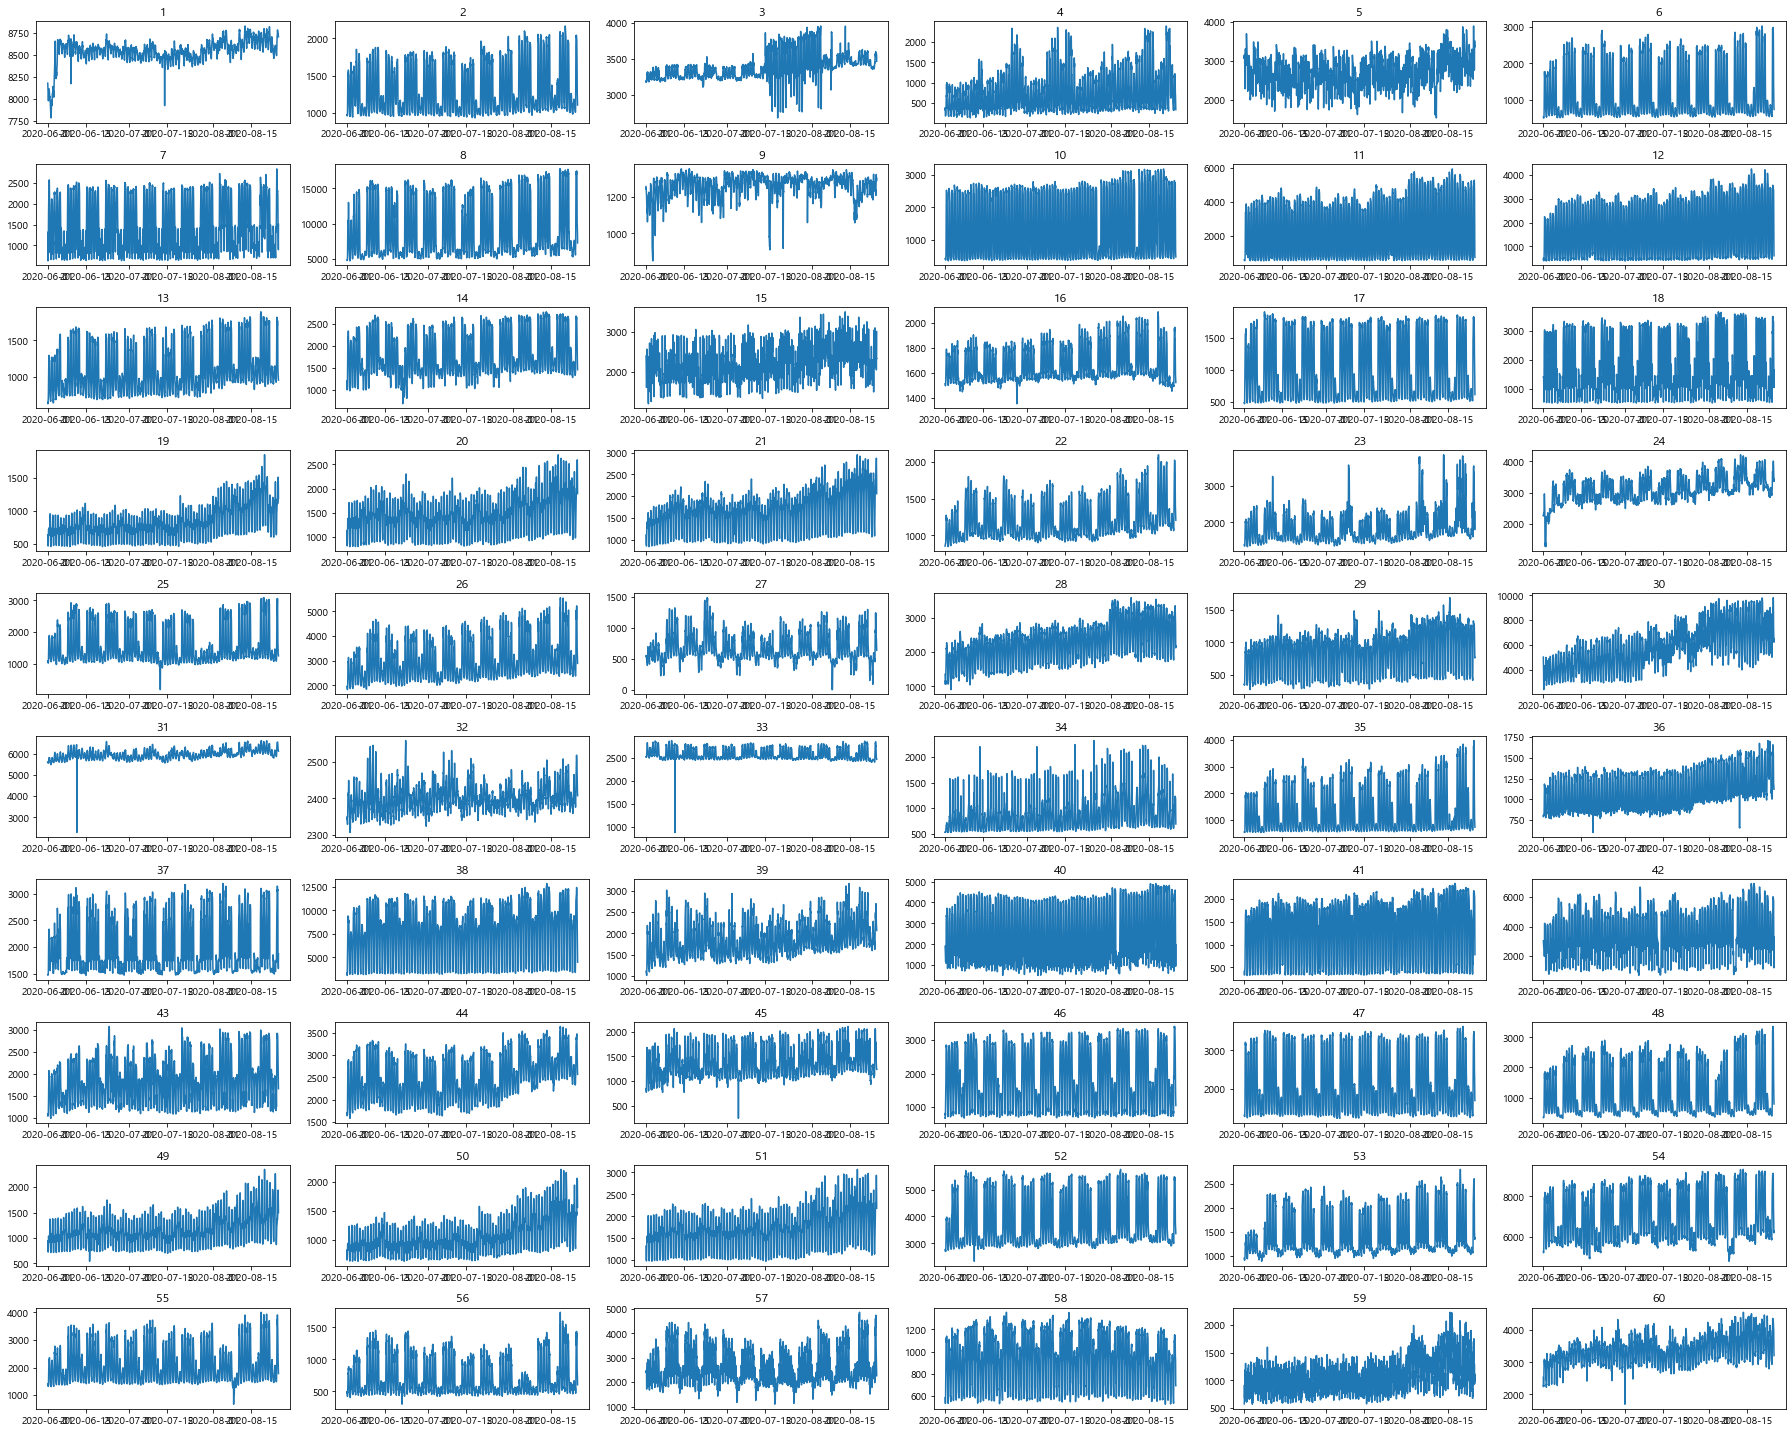

In [9]:
plt.figure(figsize=(25, 20))

for i, j in enumerate(train['num'].unique().tolist()):
    ax = plt.subplot2grid((10, 6), (i//6, i%6))
    ax.plot(train.loc[train['num'] == j]['date_time'], train.loc[train['num'] == j]['전력사용량'])
    ax.set_title(j)
    
plt.tight_layout()
plt.show()

## 시간을 활동 시간대, 아침 시간대, 저녁 시간대, 취침 시간대 4개 시간대로 재구간화

In [10]:
def rebinning_hour(x:int)->str:
    if x in [9, 10, 11, 12, 13, 14, 15, 16, 17]:
        return 'H1' # 활동 시간대
    elif x in [6, 7, 8]: 
        return 'H2' # 아침 시간대
    elif x in [18, 19, 20, 21]:
        return 'H3' # 저녁 시간대 
    elif x in [22, 23, 0, 1, 2, 3, 4, 5]:
        return 'H4' #  취침 시간대 
    
    
# 시각을 재구간화한 시간대 컬럼 추가
train['시간대'] = train['시각'].apply(rebinning_hour)
test['시간대'] = test['시각'].apply(rebinning_hour)

## 불쾌지수, 체감온도 계산

In [11]:
# 불쾌 지수 계산 
def get_thi(df:pd.DataFrame)->pd.DataFrame:
    df['불쾌지수'] = 9/5 * df['기온'] - 0.55 * (1-df['습도']/100) * (9/5 * df['기온'] - 26) + 32
    return df

train = get_thi(train)
test = get_thi(test)

In [12]:
# 체감 온도 계산
def get_wct(df:pd.DataFrame)->pd.DataFrame:
    df['체감온도'] = 13.12 + 0.6215 * df['기온'] - 11.37 * (df['풍속'] ** 0.16) + 0.3965 * (df['풍속'] ** 0.16) * df['기온']
    return df

train = get_wct(train)
test = get_wct(test)

## 불쾌지수, 체감온도를 구간화

기상청의 불쾌지수 단계별 설명 및 주의사항을 참고하여 비닝하였다. (참고 : https://www.kma.go.kr/HELP/basic/help_01_05.jsp)

In [13]:
def binning_THI(x:float)->int:
    if x >= 80:
        return 1
    elif (x >= 75) & (x < 80) :
        return 2
    elif (x >= 68) & (x < 75) :
        return 3
    elif x < 68:
        return 4
    
train['불쾌지수구간'] = train['불쾌지수'].apply(binning_THI)
test['불쾌지수구간'] = test['불쾌지수'].apply(binning_THI)

기상청의 체감온도 단계별 설명 및 주의사항을 참고하여 비닝하였다. (참고 : https://www.weather.go.kr/weather/lifenindustry/li_asset/HELP/basic/JISU_HELP_v1.1.pdf)

In [14]:
def binning_WCT(x:float)->int:
    if x >= 37:
        return 1
    elif (x >= 34) & (x < 37):
        return 2
    elif (x >= 31) & (x < 34):
        return 3
    elif (x >= 29) & (x < 31):
        return 4
    elif x < 29:
        return 5
    
train['체감온도구간'] = train['체감온도'].apply(binning_WCT)
test['체감온도구간'] = test['체감온도'].apply(binning_WCT)

## 범주형 컬럼 결합

In [15]:
# 시간대와 요일을 결합한 시간대_요일 추가
train['시간대_요일'] = train['시간대'] + '_' + train['요일'].astype(str)
test['시간대_요일'] = test['시간대'] + '_' + test['요일'].astype(str)

In [16]:
# 시간대와 주말을 결합한 시간대_주말 추가
train['시간대_주말'] = train['시간대'] + '_' + train['주말'].astype(str)
test['시간대_주말'] = test['시간대'] + '_' + test['주말'].astype(str)

In [17]:
# 시간대와 불쾌지수구간을 결합한 시간대_불쾌지수 추가 
train['시간대_불쾌지수'] = train['시간대'] + '_' + train['불쾌지수구간'].astype(str)
test['시간대_불쾌지수'] = test['시간대'] + '_' + test['불쾌지수구간'].astype(str)

In [18]:
# 시간대과 체감온도구간을 결합한 시간대_체감온도 추가 
train['시간대_체감온도'] = train['시간대'] + '_' + train['체감온도구간'].astype(str)
test['시간대_체감온도'] = test['시간대'] + '_' + test['체감온도구간'].astype(str)

In [19]:
# 시간대와 불쾌지수구간과 체감온도구간을 결합한 시간대_불쾌지수_체감온도 추가 
train['시간대_불쾌지수_체감온도'] = train['시간대']  + '_' + train['불쾌지수구간'].astype(str) + '_' + train['체감온도구간'].astype(str)
test['시간대_불쾌지수_체감온도'] = test['시간대'] + '_' + test['불쾌지수구간'].astype(str) + '_' + test['체감온도구간'].astype(str)

In [20]:
# 시간대와 요일과 불쾌지수구간을 결합한 시간대_요일_불쾌지수 추가 
train['시간대_요일_불쾌지수'] = train['시간대'] + '_' + train['요일'].astype(str) + '_' + train['불쾌지수구간'].astype(str)
test['시간대_요일_불쾌지수'] = test['시간대'] + '_' + test['요일'].astype(str) + '_' + test['불쾌지수구간'].astype(str)

In [21]:
# 시간대와 요일과 체감온도구간을 결합한 시간대_요일_체감온도 추가 
train['시간대_요일_체감온도'] = train['시간대'] + '_' + train['요일'].astype(str) + '_' + train['체감온도구간'].astype(str)
test['시간대_요일_체감온도'] = test['시간대'] + '_' + test['요일'].astype(str) + '_' + test['체감온도구간'].astype(str)

In [22]:
# 월별주수와 요일을 결합한 월별주수_요일 추가
train['월별주수_요일'] = train['월별주수'].astype(str) + '_' + train['요일'].astype(str)
test['월별주수_요일'] = test['월별주수'].astype(str) + '_' + test['요일'].astype(str)

# Clustering by Pattern Similarity

## target_stat 함수 정의 

전력 사용량에 대한 다양한 통계량을 추가하여 별도의 데이터프레임을 만들어주기 위한 함수이다.

In [23]:
def num_target_stat(df:pd.DataFrame, col_name:str)->pd.DataFrame:
    groupby = df.groupby(['num', col_name])['전력사용량']

    def q1(x:float)->float:
        return x.quantile(0.25)

    def q3(x:float)->float:
        return x.quantile(0.75)

    # median, q1, q3 통계량 
    target_stat = groupby.agg(['median', q1, q3]).add_prefix(col_name + '_').reset_index().pivot('num', col_name)
    target_stat.columns = ['_'.join(col).strip() for col in target_stat.columns.values]
    target_stat = target_stat.reset_index()

    return target_stat

## 군집화를 위한 별도 데이터프레임 만들기

In [24]:
by_col_list = ['시각', '요일', '주', '월별주수_요일', '시간대_요일', '시간대_불쾌지수', '시간대_체감온도']
cluster_df = train.copy()

for i, by_col in enumerate(by_col_list):
    cluster_df[by_col] = cluster_df[by_col].astype(str)
    if i == 0:
        cluster_df2 = num_target_stat(cluster_df, by_col)
    else:
        temp = num_target_stat(cluster_df, by_col)
        cluster_df2 = pd.merge(cluster_df2, temp, on = 'num', how = 'left')

cluster_df2 = cluster_df2.fillna(0) # 결측치는 해당 범주형 변수의 레이블에서 전력 사용량이 없었음을 의미하므로 0으로 채워줌 

# 행마다 Standard Scaling (보통 Scaler는 feature마다 동작하지만 여기서는 각 건물의 전력사용량 패턴이 비슷한 군집을 위해서 각 건물별로 스케일링)
for i in range(60):
    cluster_df2.iloc[i] = (cluster_df2.iloc[i] - cluster_df2.iloc[i].mean()) / cluster_df2.iloc[i].std()

## 계층적 군집화 및 덴드로그램 시각화

Text(0.5, 0, 'num')

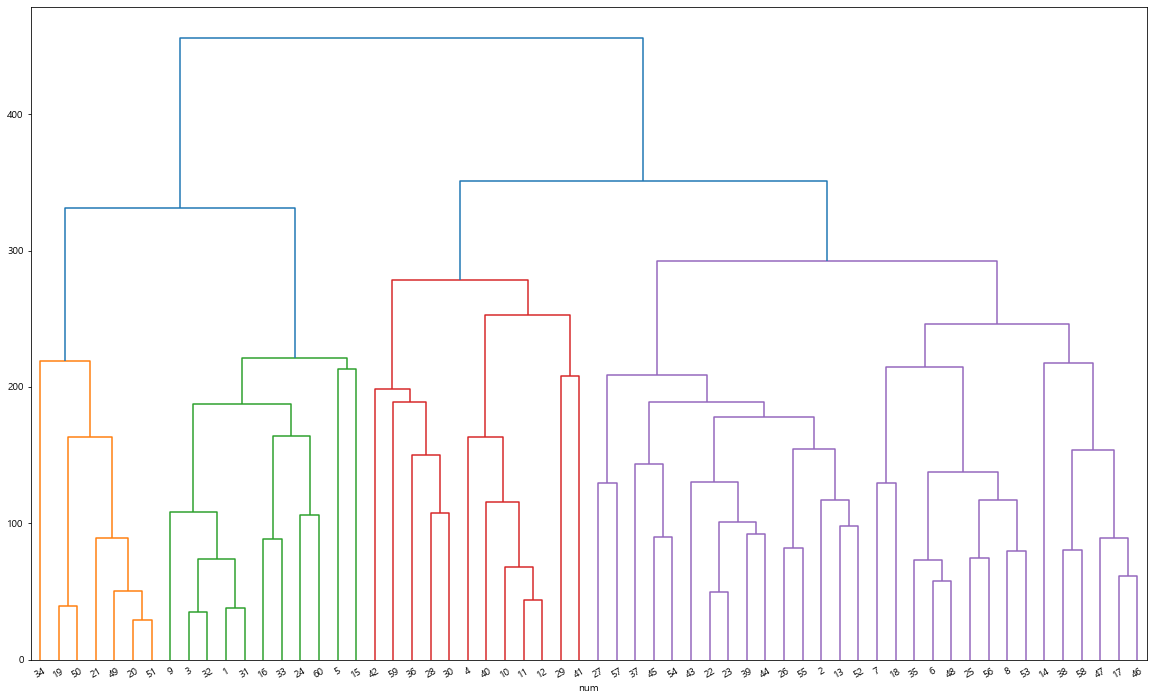

In [25]:
cluster_complete = linkage(cluster_df2, method = 'complete', metric = 'cityblock')

plt.figure(figsize = (20, 12))
dendrogram(cluster_complete, leaf_font_size = 10, leaf_label_func = lambda x: x+1, leaf_rotation = 30)
plt.xlabel('num', fontsize = 10)

## 군집화한 결과를 컬럼으로 추가

In [26]:
fclust = fcluster(cluster_complete, 4, criterion='maxclust')
fclust_dict = {}

for i, fc in enumerate(fclust):
    fclust_dict[i+1] = fc
    
train['cluster'] = train['num'].apply(lambda x: fclust_dict[x])
test['cluster'] = test['num'].apply(lambda x: fclust_dict[x]) 

## 군집별 전력사용량 추이 시각화

### 군집별 개별 건물들의 시간에 따른 전력사용량 추이 

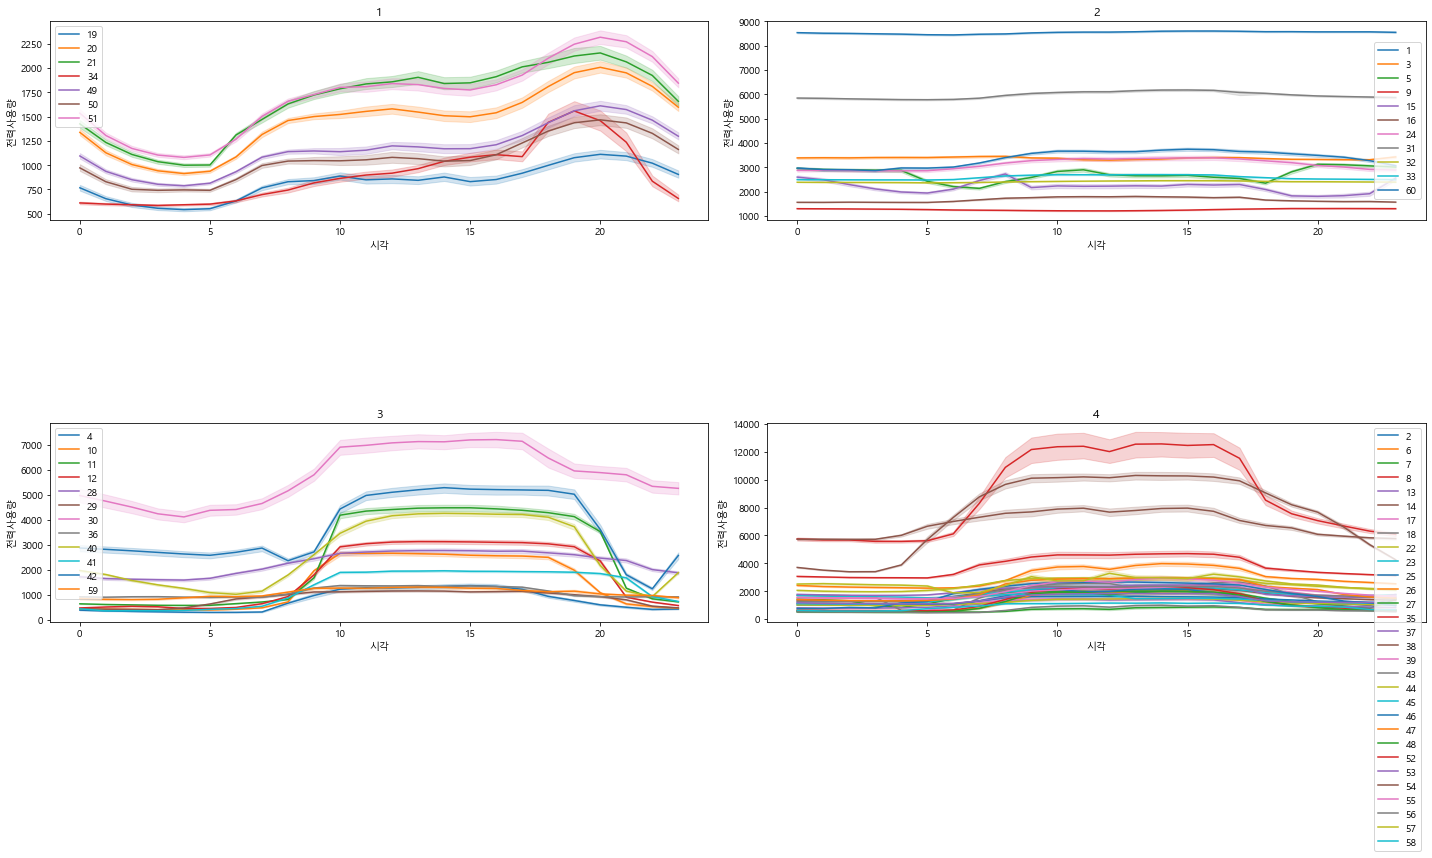

In [27]:
fig = plt.figure(figsize=(20, 5*train['cluster'].nunique()))

for i, c in enumerate(sorted(train['cluster'].unique())):
    ax = fig.add_subplot(train['cluster'].nunique(), 2, i+1)
    ax.set(title=c)
    for num in sorted(train.loc[train['cluster'] == c]['num'].unique()):
        sns.lineplot(train.loc[train['num'] == num]['시각'], train.loc[train['num'] == num]['전력사용량'])
        plt.legend(sorted(train.loc[train['cluster'] == c]['num'].unique()))

plt.tight_layout()
plt.show()

### 군집별 개별 건물들의 요일에 따른 전력사용량 추이 

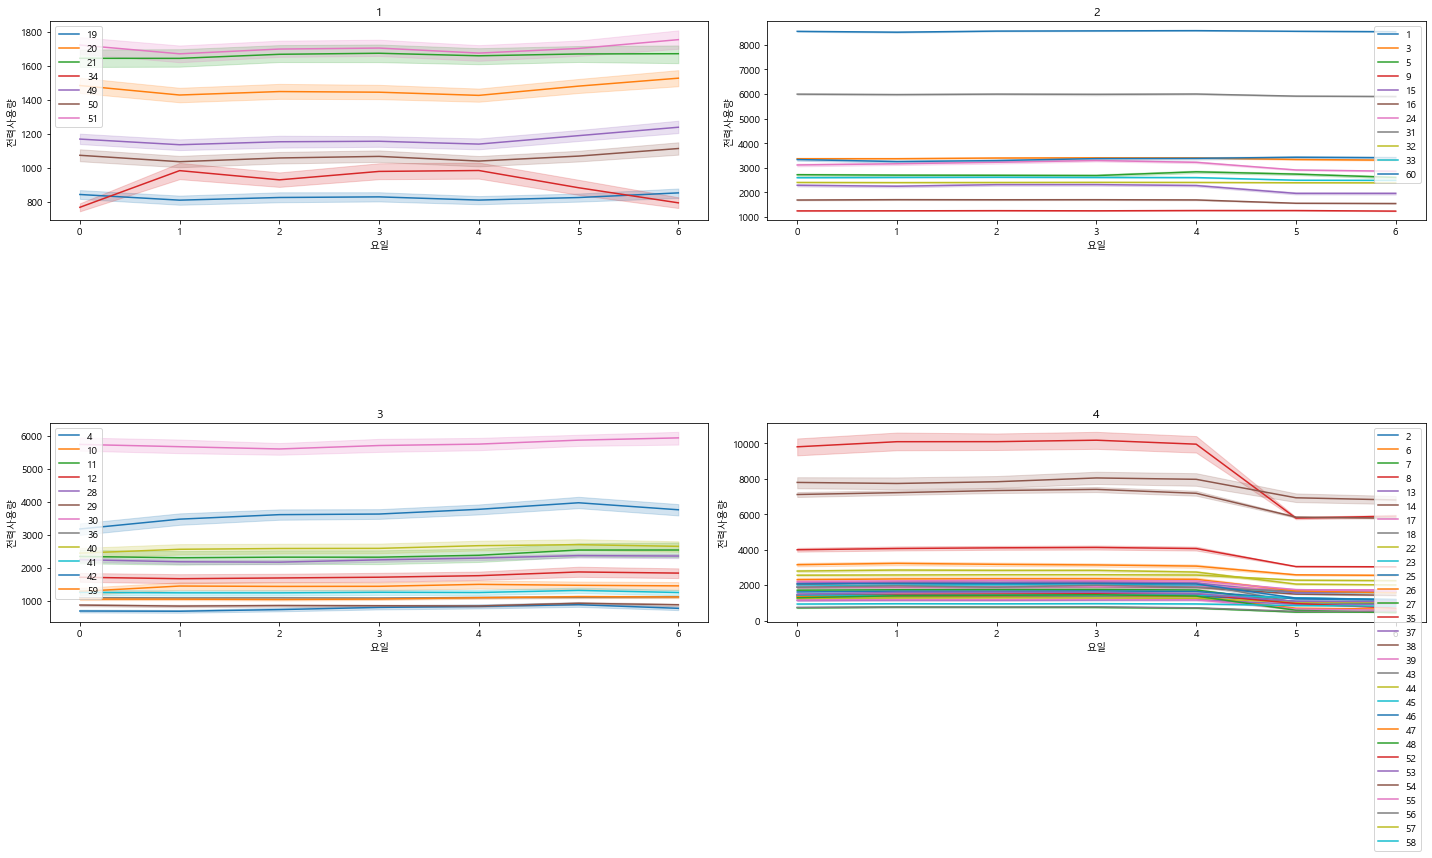

In [28]:
fig = plt.figure(figsize=(20, 5*train['cluster'].nunique()))

for i, c in enumerate(sorted(train['cluster'].unique())):
    ax = fig.add_subplot(train['cluster'].nunique(), 2, i+1)
    ax.set(title=c)
    for num in sorted(train.loc[train['cluster'] == c]['num'].unique()):
        sns.lineplot(train.loc[train['num'] == num]['요일'], train.loc[train['num'] == num]['전력사용량'])
        plt.legend(sorted(train.loc[train['cluster'] == c]['num'].unique()))

plt.tight_layout()
plt.show()

### 군집별 개별 건물들의 시간대_요일에 따른 전력사용량 추이 

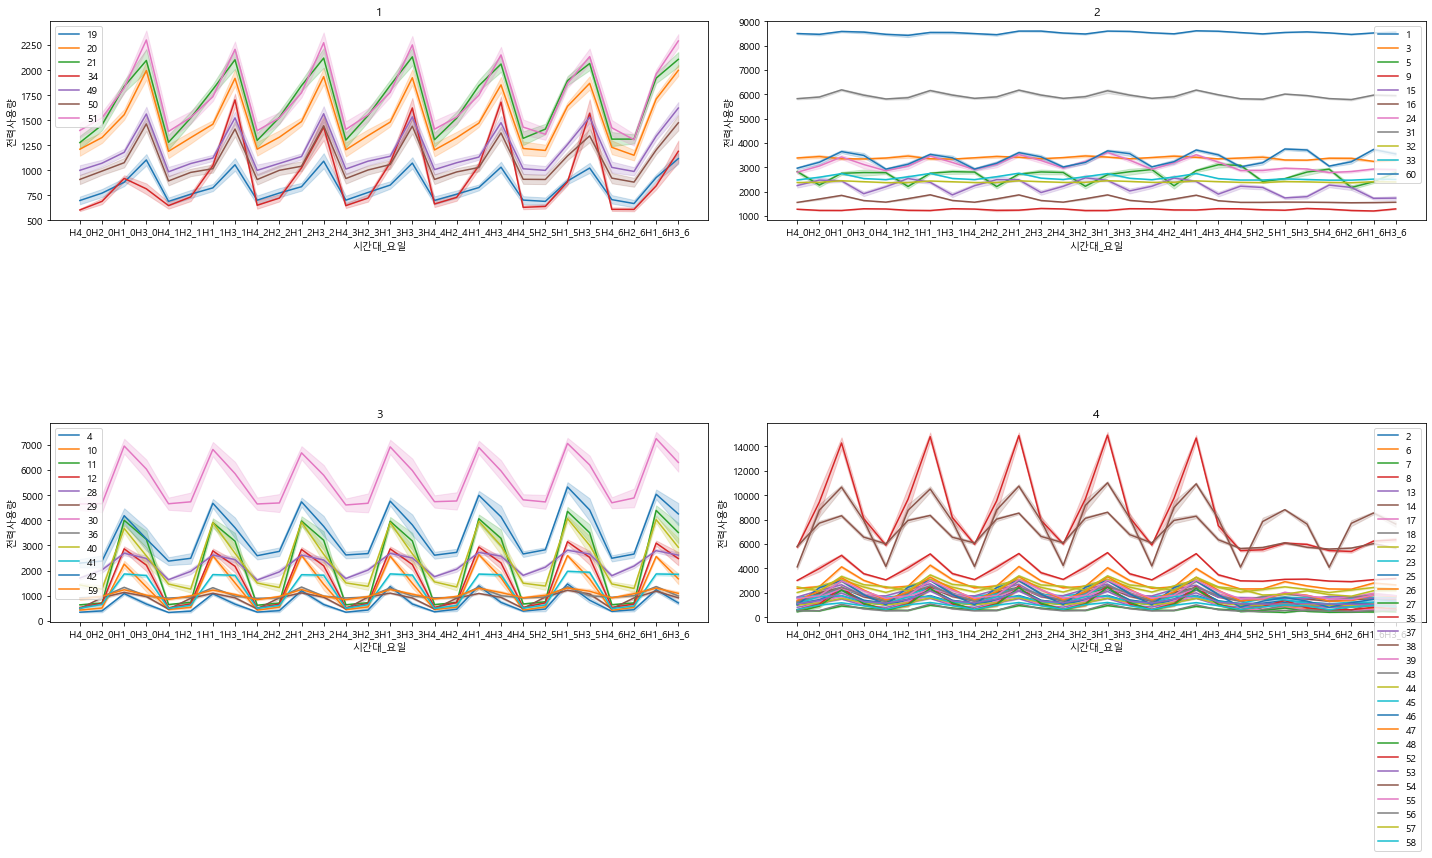

In [29]:
fig = plt.figure(figsize=(20, 5*train['cluster'].nunique()))

for i, c in enumerate(sorted(train['cluster'].unique())):
    ax = fig.add_subplot(train['cluster'].nunique(), 2, i+1)
    ax.set(title=c)
    for num in sorted(train.loc[train['cluster'] == c]['num'].unique()):
        sns.lineplot(train.loc[train['num'] == num]['시간대_요일'], train.loc[train['num'] == num]['전력사용량'])
        plt.legend(sorted(train.loc[train['cluster'] == c]['num'].unique()))

plt.tight_layout()
plt.show()

## cluster 별 특징 요약

1. **cluster1**
    시간적으로는 저녁 시간대 사용량이 많고 요일은 평일과 주말 모두 일정한 편이지만 주말에 더 많은 편이다. 또한 기상요소에 영향을 받기도 하므로 사람이 생활하는 공간 중 주거지 등으로 추정된다.

2. **cluster2**
    공장과 같이 계속 일정하게 전력을 사용하는 건물일 확률이 높다.

3. **cluster3**
    오전 9시부터 저녁 9시까지의 사용량이 많고 요일에 따른 변동폭이 크지 않으며 기상요소에 영향을 받기도 하므로 사람이 생활하는 공간 중 상업시설 등으로 추정된다.

4. **cluster4**
    오전 6-8시부터 저녁 5-7시까지 사용량이 많고 평일에 사용량이 많다가 주말에 사용량이 급격히 감소하며 기상요소에도 영향을 받으므로 사람이 생활하는 공간 중 공관서나 회사 등의 근무지일 확률이 높다.

# Anomaly Detection

## 건물별 이상치 탐지

In [31]:
for num in range(1, 61):
    num_outliers, dt_outliers = filter_outlier_sd(train, num)
    print(f'건물 {num}')
    print(f'탐지된 아웃라이어 개수 : {num_outliers} 개')
    print(f'탐지된 아웃라이어 날짜와 시각 정보 : \n {dt_outliers}')
    print('=' * 80)

건물 1
탐지된 아웃라이어 개수 : 17 개
탐지된 아웃라이어 날짜와 시각 정보 : 
 0      2020-06-01 00:00:00
62     2020-06-03 14:00:00
63     2020-06-03 15:00:00
64     2020-06-03 16:00:00
65     2020-06-03 17:00:00
66     2020-06-03 18:00:00
70     2020-06-03 22:00:00
71     2020-06-03 23:00:00
72     2020-06-04 00:00:00
73     2020-06-04 01:00:00
204    2020-06-09 12:00:00
1033   2020-07-14 01:00:00
1034   2020-07-14 02:00:00
1161   2020-07-19 09:00:00
1497   2020-08-02 09:00:00
1505   2020-08-02 17:00:00
1983   2020-08-22 15:00:00
Name: date_time, dtype: datetime64[ns]
건물 2
탐지된 아웃라이어 개수 : 2 개
탐지된 아웃라이어 날짜와 시각 정보 : 
 4078   2020-08-24 22:00:00
4079   2020-08-24 23:00:00
Name: date_time, dtype: datetime64[ns]
건물 3
탐지된 아웃라이어 개수 : 32 개
탐지된 아웃라이어 날짜와 시각 정보 : 
 5174   2020-07-16 14:00:00
5196   2020-07-17 12:00:00
5222   2020-07-18 14:00:00
5244   2020-07-19 12:00:00
5246   2020-07-19 14:00:00
5267   2020-07-20 11:00:00
5268   2020-07-20 12:00:00
5269   2020-07-20 13:00:00
5270   2020-07-20 14:00:00
5291   2020-07-21 11

건물 23
탐지된 아웃라이어 개수 : 38 개
탐지된 아웃라이어 날짜와 시각 정보 : 
 45131   2020-06-11 11:00:00
45132   2020-06-11 12:00:00
45802   2020-07-09 10:00:00
45803   2020-07-09 11:00:00
45804   2020-07-09 12:00:00
45808   2020-07-09 16:00:00
46055   2020-07-19 23:00:00
46426   2020-08-04 10:00:00
46427   2020-08-04 11:00:00
46428   2020-08-04 12:00:00
46429   2020-08-04 13:00:00
46430   2020-08-04 14:00:00
46431   2020-08-04 15:00:00
46437   2020-08-04 21:00:00
46641   2020-08-13 09:00:00
46642   2020-08-13 10:00:00
46643   2020-08-13 11:00:00
46644   2020-08-13 12:00:00
46645   2020-08-13 13:00:00
46646   2020-08-13 14:00:00
46763   2020-08-18 11:00:00
46764   2020-08-18 12:00:00
46787   2020-08-19 11:00:00
46788   2020-08-19 12:00:00
46806   2020-08-20 06:00:00
46809   2020-08-20 09:00:00
46810   2020-08-20 10:00:00
46811   2020-08-20 11:00:00
46812   2020-08-20 12:00:00
46816   2020-08-20 16:00:00
46835   2020-08-21 11:00:00
46836   2020-08-21 12:00:00
46914   2020-08-24 18:00:00
46915   2020-08-24 19:00:0

Name: date_time, dtype: datetime64[ns]
건물 39
탐지된 아웃라이어 개수 : 15 개
탐지된 아웃라이어 날짜와 시각 정보 : 
 77554   2020-06-02 10:00:00
77606   2020-06-04 14:00:00
77702   2020-06-08 14:00:00
77703   2020-06-08 15:00:00
77724   2020-06-09 12:00:00
77726   2020-06-09 14:00:00
77745   2020-06-10 09:00:00
77796   2020-06-12 12:00:00
78230   2020-06-30 14:00:00
78280   2020-07-02 16:00:00
78346   2020-07-05 10:00:00
78512   2020-07-12 08:00:00
78949   2020-07-30 13:00:00
79211   2020-08-10 11:00:00
79313   2020-08-14 17:00:00
Name: date_time, dtype: datetime64[ns]
건물 40
탐지된 아웃라이어 개수 : 21 개
탐지된 아웃라이어 날짜와 시각 정보 : 
 79566   2020-06-01 06:00:00
79639   2020-06-04 07:00:00
80352   2020-07-04 00:00:00
81076   2020-08-03 04:00:00
81077   2020-08-03 05:00:00
81078   2020-08-03 06:00:00
81079   2020-08-03 07:00:00
81083   2020-08-03 11:00:00
81084   2020-08-03 12:00:00
81085   2020-08-03 13:00:00
81086   2020-08-03 14:00:00
81087   2020-08-03 15:00:00
81088   2020-08-03 16:00:00
81089   2020-08-03 17:00:00
81090   20

## 건물별 이상치 탐지 결과 시각화

건물별 전력사용량 추이에서 탐지한 이상치를 빨간색 점으로 표시하였다.

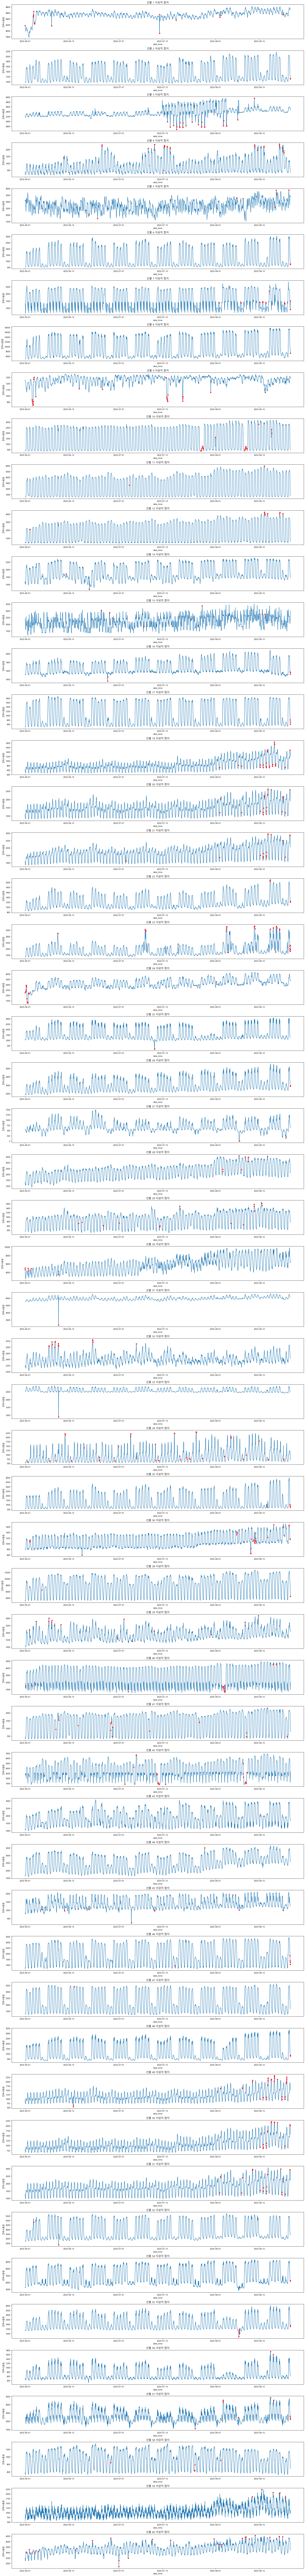

In [33]:
plot_mark_outlier(train, range(1, 61))

## 이상치 탐지 결과 해석

1. **cluster 1**
시간적으로는 저녁 시간대 사용량이 많고 요일은 평일과 주말 모두 일정한 편이지만 주말에 더 많은 편이다. 또한 기상요소에 영향을 받기도 하므로 사람이 생활하는 공간 중 주거지 등으로 추정된다. 따라서 이 cluster 1에 속한 건물들은 주거지 특성상 평소에도 여러가지 요소 인해 전력 사용량 변동이 많기 때문에 잔차 분포 뿐만 아니라 이동평균, K Means Clustering 등으로 걸러냈을 때 이상치 후보가 없었다. 
<br><br>
2. **cluster 2**
분류된 건물 1, 9, 31, 33, 60는 평소 전력 사용량이 시간, 요일, 기상 요소등과 관계없이 일정한 편이므로 사람이 생활하는 공간이라기보다는 공장과 같이 계속 전력을 사용하는 건물일 확률이 높다. 따라서 이상치가 발생한 부분은 대체해주는 것이 성능향상에 도움될 것으로 판단된다.
<br><br>
3. **cluster 3**
건물 10, 36, 40, 42는 오전 9시부터 저녁 9시까지의 사용량이 많고 요일에 따른 변동폭이 크지 않으며 기상요소에 영향을 받기도 하므로 사람이 생활하는 공간 중 상업시설 등으로 추정된다. 이 cluster3 건물들은 이상치가 하나의 시간으로 나타난다기보다는 거의 하루 정도로 크게 나타나고 있는데 상업시설 내의 휴무일이거나 공휴일, 기념일, 재택근무 등으로 인한 특이치일 수 있으므로 신중히 대체하도록 한다. 
<br><br>
4. **cluster 4**
건물 25, 45, 52, 55은 오전 6-8시부터 저녁 5-7시까지 사용량이 많고 평일에 사용량이 많다가 주말에 사용량이 급격히 감소하며 기상요소에도 영향을 받으므로 사람이 생활하는 공간 중 공관서 나 회사 등의 근무지일 확률이 높다. 이 때 건물 25, 45, 52, 55의 이상치는 한시간 내의 이상치이기 때문에 정전 등으로 인한 극단치일 확률이 높아 대체해주는 것이 성능향상에 도움될 것으로 판단된다.

## 이상치 대체

이상치를 동일 범주의 시각 및 요일의 중앙값으로 대체하였다. 시계열 데이터에서 만약 같은 시각과 요일에 주기적으로 전력 사용을 하지 않는 등의 사건이 있다면 그건 이상치라기보다는 특이치므로 test 데이터셋에서도 학습할 수 있도록 내버려두어야 하기 때문에 이런 방식으로 이상치를 대체하였다. 

In [ ]:
def replace_outlier(df:pd.DataFrame, num:int, dt_list:list)->pd.DataFrame:
    # 건물별 이상치 대체 
    df_num = df.loc[df['num'] == num]
    groupby_stat = df_num.groupby(['시각', '요일'])['전력사용량'].median().to_frame('전력사용량_median').reset_index()

    for dt in dt_list:
        hr = df_num.loc[df_num['date_time'] == dt]['시각'].item()
        wd = df_num.loc[df_num['date_time'] == dt]['요일'].item()
        median = groupby_stat.loc[(groupby_stat['시각'] == hr) & (groupby_stat['요일'] == wd)]['전력사용량_median'].item()
        df_num.loc[df_num['date_time'] == dt, '전력사용량'] = median
    
    df.loc[df['num'] == num, '전력사용량'] = df_num['전력사용량']
    
    return df

In [35]:
# cluster 1에 속한 건물 이상치 처리 
train = replace_outlier(train, 1, ['2020-06-09 12:00:00', '2020-07-14 01:00:00', '2020-07-14 02:00:00'])
train = replace_outlier(train, 9, pd.date_range('2020-06-03 06:00:00', freq = '60min', periods = 16).tolist() + pd.date_range('2020-07-16 04:00:00', freq = '60min', periods = 14).tolist() + pd.date_range('2020-07-21 10:00:00', freq = '60min', periods = 4).tolist())
train = replace_outlier(train, 31, ['2020-06-11 17:00:00'])
train = replace_outlier(train, 33, ['2020-06-11 17:00:00'])
train = replace_outlier(train, 60, ['2020-07-01 01:00:00', '2020-07-01 01:00:00'])

In [36]:
# cluster 3에 속한 건물 이상치 처리 
train = replace_outlier(train, 10, pd.date_range('2020-07-27 04:00:00', freq = '60min', periods = 22).tolist() + pd.date_range('2020-08-10 04:00:00', freq = '60min', periods = 22).tolist())
train = replace_outlier(train, 36, ['2020-06-19 06:00:00'] + pd.date_range('2020-08-12 05:00:00', freq = '60min', periods = 5).tolist())
train = replace_outlier(train, 40, pd.date_range('2020-08-03 04:00:00', freq = '60min', periods = 4).tolist() + pd.date_range('2020-08-03 11:00:00', freq = '60min', periods = 13).tolist())
train = replace_outlier(train, 42, pd.date_range('2020-07-13 05:00:00', freq = '60min', periods = 3).tolist() + pd.date_range('2020-07-13 10:00:00', freq = '60min', periods = 13).tolist() + pd.date_range('2020-08-10 11:00:00', freq = '60min', periods = 9).tolist())

In [37]:
# cluster 4에 속한 건물 이상치 처리 
train = replace_outlier(train, 25, pd.date_range('2020-07-12 10:00:00', freq = '60min', periods = 2).tolist())
train = replace_outlier(train, 45, ['2020-07-05 01:00:00'])
train = replace_outlier(train, 52, ['2020-06-11 18:00:00'])
train = replace_outlier(train, 55, pd.date_range('2020-08-08 15:00:00', freq = '60min', periods = 3).tolist())

## 이상치가 탐지된 건물의 이상치 대체 후 전력 사용량 추이 시각화

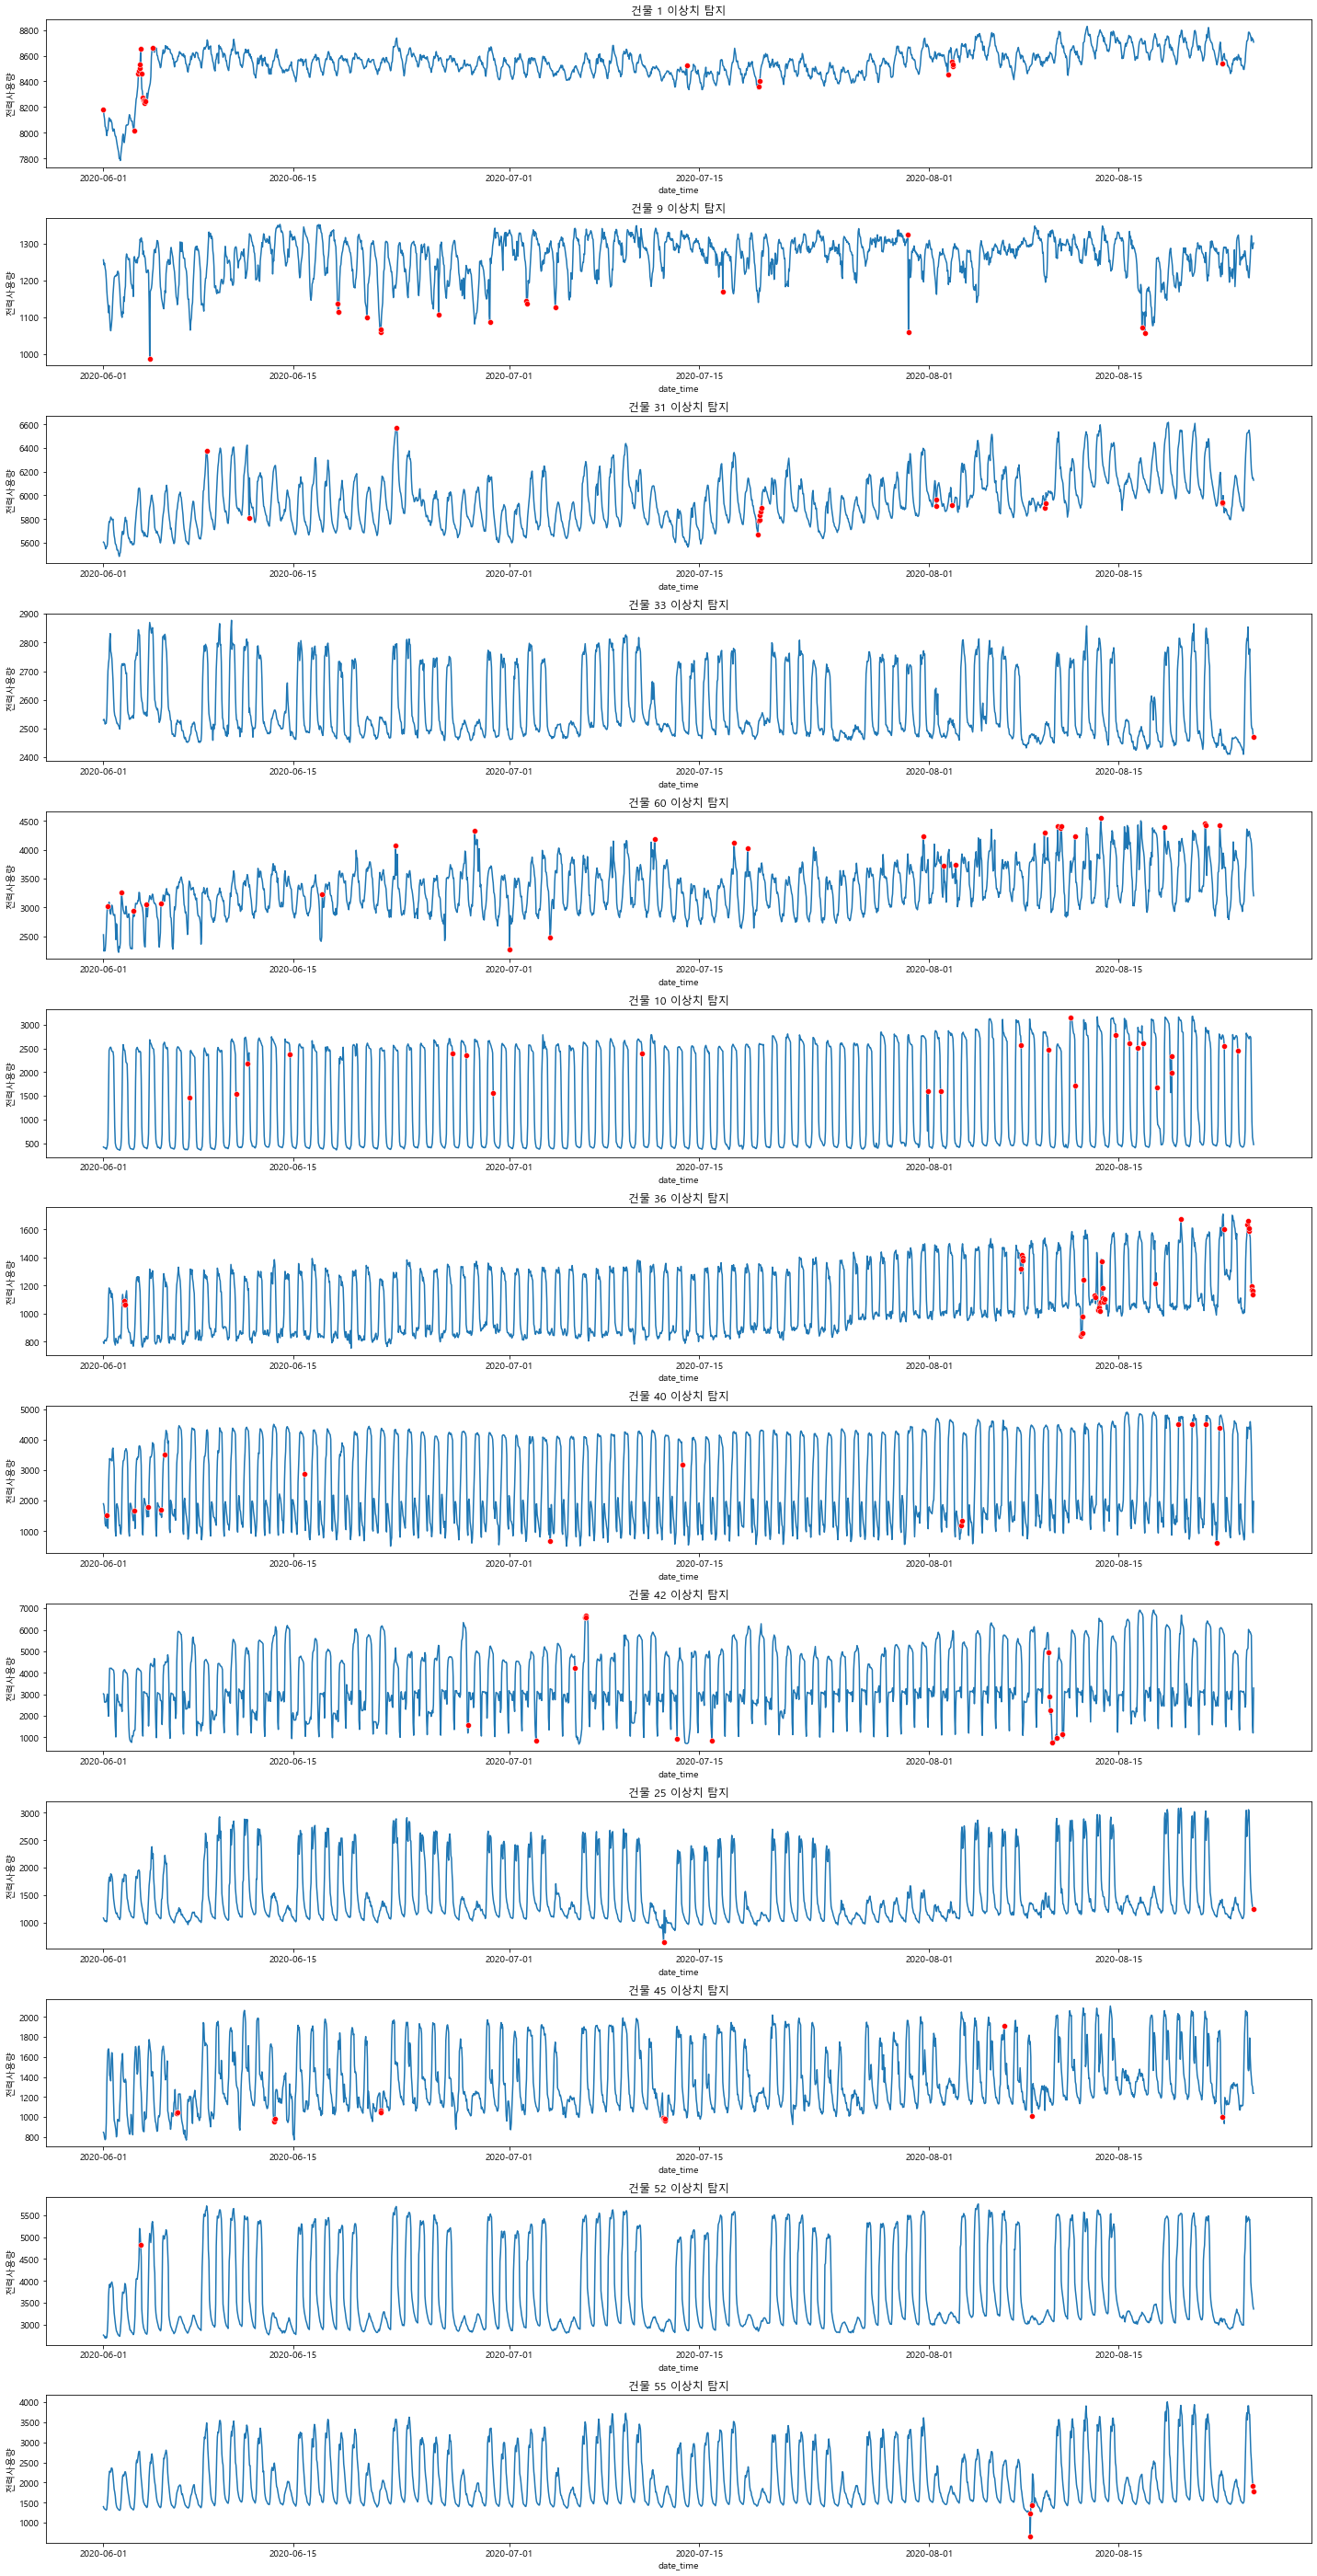

In [38]:
plot_mark_outlier(train, [1, 9, 31, 33, 60, 10, 36, 40, 42, 25, 45, 52, 55])

# Time Series Data Stationary Test & Skewness Test

## 시계열 데이터의 정상성 (Stationary) 테스트 

건물별로 Augmented Dickey-Fuller Test를 진행하였다.

In [39]:
for num in range(1, 61):
    print(f'건물 {num}')
    adf_result = adfuller(train.loc[train['num'] == num]['전력사용량'])
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    print(f'#Lags Used: {adf_result[2]}')
    print(f'#Observations Used: {adf_result[3]}')
    for key, value in adf_result[4].items():
        print(f'Critical Values: {key, value}')
    
    print('=' * 60)

건물 1
ADF Statistic: -6.095556240996166
p-value: 1.0121067802199099e-07
#Lags Used: 26
#Observations Used: 2013
Critical Values: ('1%', -3.4336026867364144)
Critical Values: ('5%', -2.8629768669694458)
Critical Values: ('10%', -2.5675349256978177)
건물 2
ADF Statistic: -6.205479895117741
p-value: 5.671583492170958e-08
#Lags Used: 26
#Observations Used: 2013
Critical Values: ('1%', -3.4336026867364144)
Critical Values: ('5%', -2.8629768669694458)
Critical Values: ('10%', -2.5675349256978177)
건물 3
ADF Statistic: -2.5357959851987384
p-value: 0.10700588280693957
#Lags Used: 26
#Observations Used: 2013
Critical Values: ('1%', -3.4336026867364144)
Critical Values: ('5%', -2.8629768669694458)
Critical Values: ('10%', -2.5675349256978177)
건물 4
ADF Statistic: -3.6331239011147107
p-value: 0.005158447049010762
#Lags Used: 26
#Observations Used: 2013
Critical Values: ('1%', -3.4336026867364144)
Critical Values: ('5%', -2.8629768669694458)
Critical Values: ('10%', -2.5675349256978177)
건물 5
ADF Statist

ADF Statistic: -1.668753240842986
p-value: 0.44727936210922314
#Lags Used: 26
#Observations Used: 2013
Critical Values: ('1%', -3.4336026867364144)
Critical Values: ('5%', -2.8629768669694458)
Critical Values: ('10%', -2.5675349256978177)
건물 29
ADF Statistic: -2.642422887402862
p-value: 0.08454240334371099
#Lags Used: 25
#Observations Used: 2014
Critical Values: ('1%', -3.4336010696328323)
Critical Values: ('5%', -2.8629761530066187)
Critical Values: ('10%', -2.567534545549574)
건물 30
ADF Statistic: -1.421870065945887
p-value: 0.5717475937184626
#Lags Used: 26
#Observations Used: 2013
Critical Values: ('1%', -3.4336026867364144)
Critical Values: ('5%', -2.8629768669694458)
Critical Values: ('10%', -2.5675349256978177)
건물 31
ADF Statistic: -4.0273537761314
p-value: 0.0012738608645732892
#Lags Used: 24
#Observations Used: 2015
Critical Values: ('1%', -3.43359945413637)
Critical Values: ('5%', -2.8629754397529616)
Critical Values: ('10%', -2.5675341657789903)
건물 32
ADF Statistic: -5.517210

ADF Statistic: -5.332455859877885
p-value: 4.688699618825573e-06
#Lags Used: 25
#Observations Used: 2014
Critical Values: ('1%', -3.4336010696328323)
Critical Values: ('5%', -2.8629761530066187)
Critical Values: ('10%', -2.567534545549574)
건물 57
ADF Statistic: -6.002483291389205
p-value: 1.644776113679868e-07
#Lags Used: 26
#Observations Used: 2013
Critical Values: ('1%', -3.4336026867364144)
Critical Values: ('5%', -2.8629768669694458)
Critical Values: ('10%', -2.5675349256978177)
건물 58
ADF Statistic: -6.573515253182248
p-value: 7.828485888197742e-09
#Lags Used: 26
#Observations Used: 2013
Critical Values: ('1%', -3.4336026867364144)
Critical Values: ('5%', -2.8629768669694458)
Critical Values: ('10%', -2.5675349256978177)
건물 59
ADF Statistic: -1.6598176138803808
p-value: 0.4519254140988468
#Lags Used: 26
#Observations Used: 2013
Critical Values: ('1%', -3.4336026867364144)
Critical Values: ('5%', -2.8629768669694458)
Critical Values: ('10%', -2.5675349256978177)
건물 60
ADF Statistic: 

건물별 Augmented Dickey-Fuller Test 진행하여 p-value가 0.05 이상인 경우(non-stationary)만 출력한다.

In [40]:
non_stationary = []

for num in range(1, 61):
    adf_result = adfuller(train.loc[train['num'] == num]['전력사용량'])
    p_value = adf_result[1]
    if p_value >= 0.05:
        non_stationary.append(num)

print(non_stationary)

[3, 10, 11, 19, 20, 21, 28, 29, 30, 36, 49, 50, 51, 59, 60]


## 왜도가 0.8 이상인 경우 탐지

건물별 전력 사용량의 히스토그램을 시각화하여 왜도를 대략적으로 확인한다.

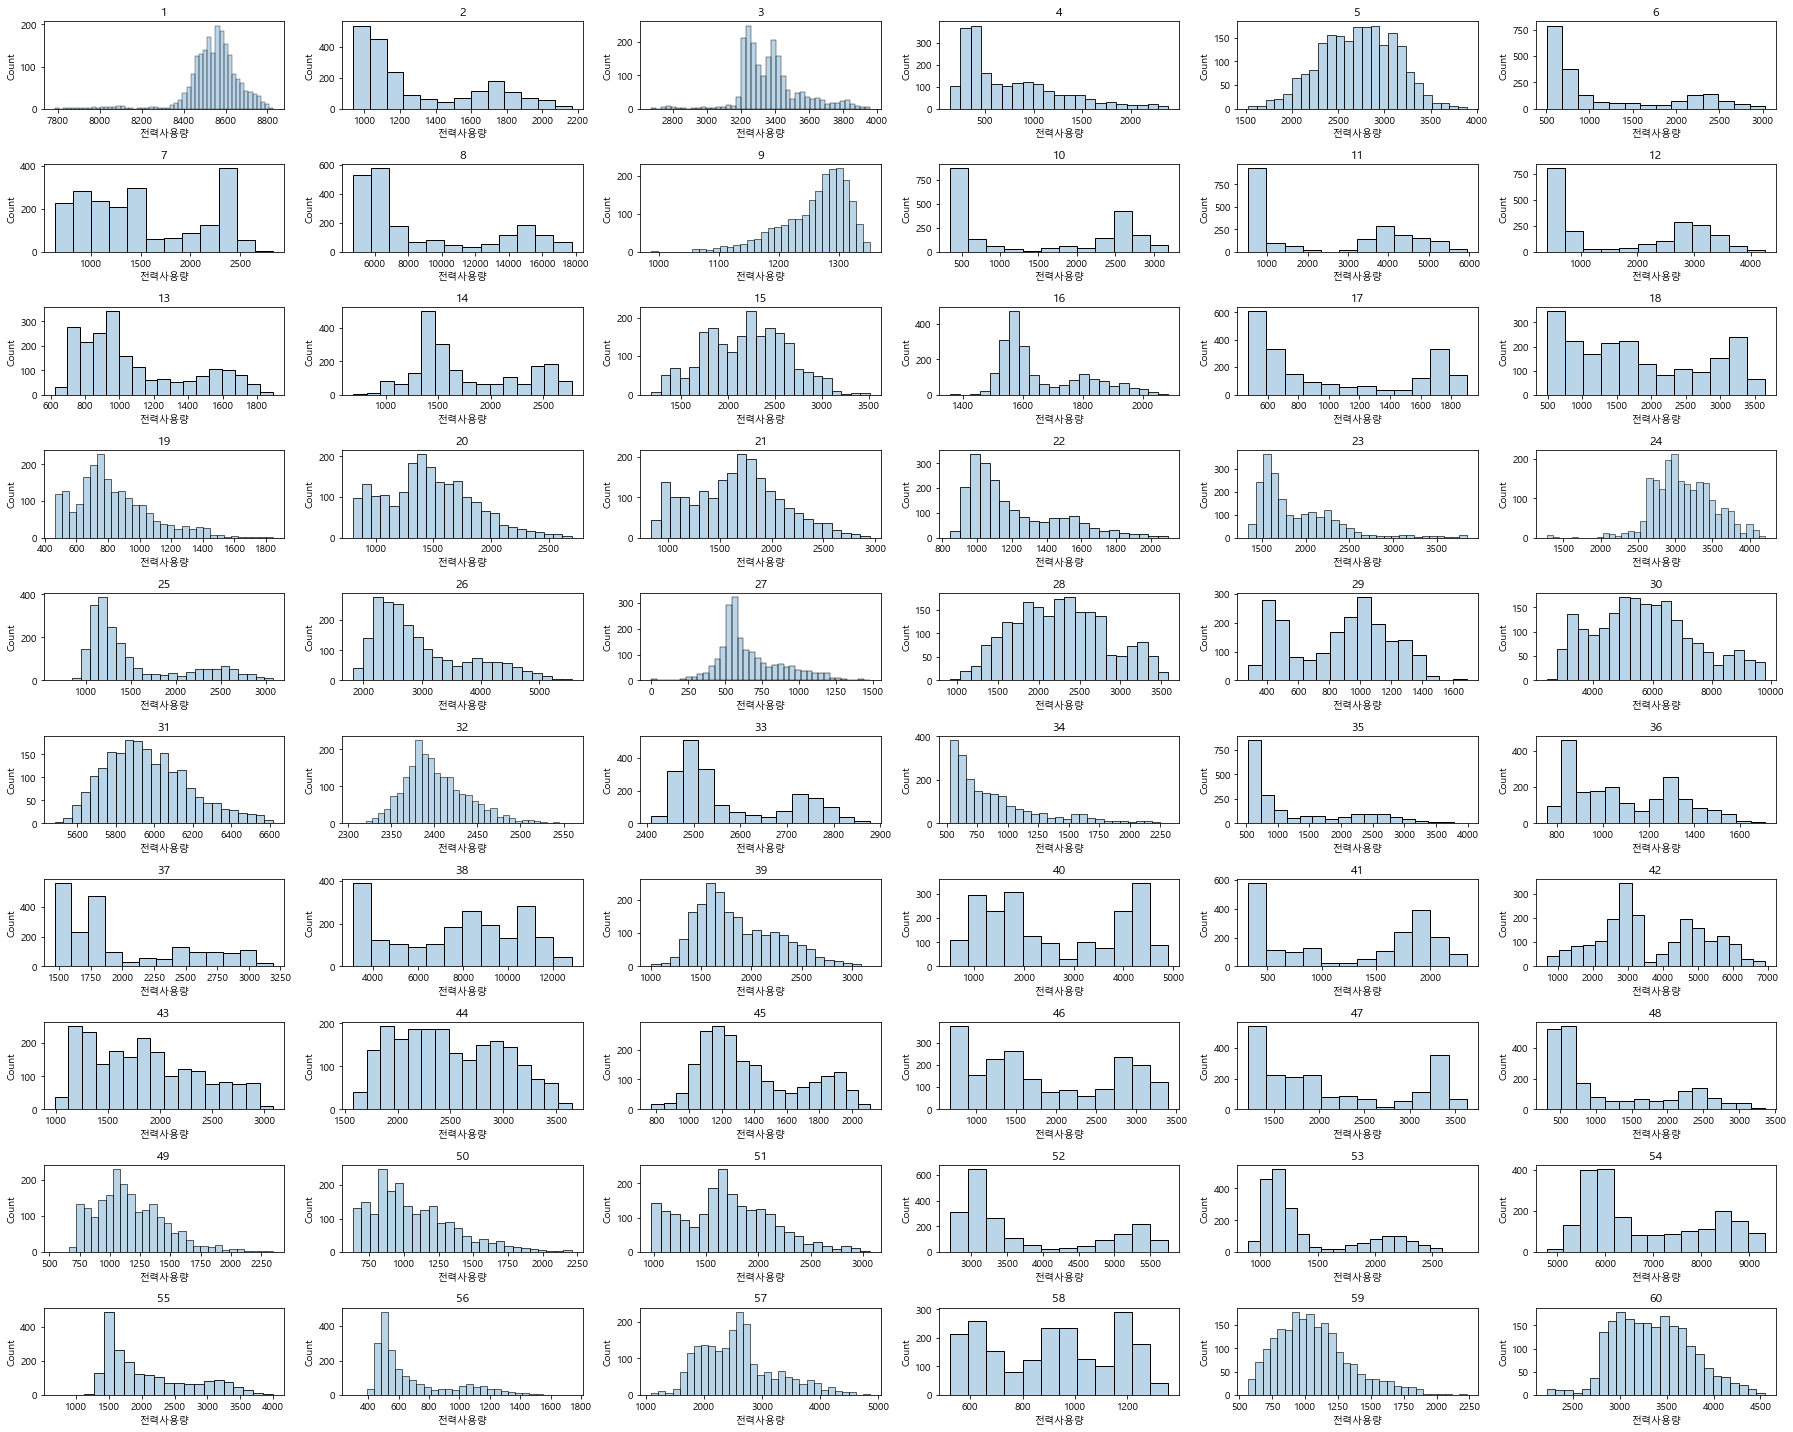

In [41]:
plt.figure(figsize=(25, 20))

for i, j in enumerate(sorted(train['num'].unique())):
    ax = plt.subplot2grid((10, 6), (i//6, i%6))
    sns.histplot(data = train.loc[train['num'] == j], x = '전력사용량', alpha =0.3, ax = ax)
    ax.set_title(j)
    
plt.tight_layout()
plt.show()

비정상 시계열 데이터거나 왜도가 0.8 이상인 경우를 탐지하여 모델링 시 로그 변환해줄 건물을 log_num 리스트로 그루핑한다. 

In [42]:
skewness_df = train.groupby('num')['전력사용량'].skew().to_frame('skewness').reset_index()
log_num = sorted(skewness_df[skewness_df['skewness'] > 0.8]['num']) # right-skewd data 
log_num = sorted(log_num + non_stationary) # non-stationary data
print(log_num)

[2, 3, 4, 6, 8, 10, 11, 16, 19, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 34, 35, 36, 37, 48, 49, 49, 50, 50, 51, 53, 55, 56, 59, 59, 60]


# Encoding

In [43]:
cat_cols = train.columns[train.dtypes == object].tolist()
del_col_list = ['num', 'date_time', '날짜', '일', '월별주수_요일', '비전기냉방설비운영', '태양광보유', 'cluster']

for i in del_col_list:
    if i in cat_cols:
        cat_cols.remove(i)

In [44]:
# 범주형 변수 Label Ecnoding

le = LabelEncoder()

for i in cat_cols:
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])

# Modeling

In [45]:
# SMAPE 함수 정의 (A=actual, F=forecast)
def SMAPE(A, F):
    return np.mean((abs(F-A))/((abs(A) + abs(F))/2)) * 100

cluster별 전력사용량과 다른 피쳐들간의 상관계수를 파악하여 각 건물이 속한 cluster별로 피쳐 선택을 다르게 할 때 참고한다.

In [46]:
for cluster in range(1, 5):
    print(f'cluster {cluster}')
    print(train.loc[train['cluster'] == cluster].corr()['전력사용량'])
    print('=' * 80)

cluster 1
num              0.032037
전력사용량            1.000000
기온               0.435392
풍속               0.025719
습도              -0.116006
강수량              0.002724
일조               0.056538
비전기냉방설비운영       -0.298753
태양광보유            0.296976
월                0.275330
주                0.278929
일                0.021872
시각               0.488097
요일               0.019365
주말               0.017190
월별주수             0.017840
시간대             -0.181530
불쾌지수             0.449440
체감온도             0.429808
불쾌지수구간          -0.410487
체감온도구간          -0.306209
시간대_요일          -0.172962
시간대_주말          -0.175876
시간대_불쾌지수        -0.230656
시간대_체감온도        -0.196900
시간대_불쾌지수_체감온도   -0.231430
시간대_요일_불쾌지수     -0.180456
시간대_요일_체감온도     -0.173665
cluster               NaN
Name: 전력사용량, dtype: float64
cluster 2
num             -0.127798
전력사용량            1.000000
기온               0.084875
풍속               0.186301
습도              -0.153540
강수량             -0.004559
일조              -0.015585
비전기냉방설비운영       

In [47]:
target = '전력사용량'
cv_score_agg = pd.DataFrame({'num' : range(1, 61), 'cv_score' : 0}) # 건물별 모델링 결과를 모아놓을 데이터프레임 (추후 평균낼 예정)
lgb_pred_test = np.zeros(test.shape[0]) # test 데이터에 대한 예측 결과 


# 교차검증을 위한 validation set 
valid_date_list = pd.date_range(start='2020-08-18', end ='2020-08-24').strftime('%Y-%m-%d').to_list() + \
pd.date_range(start='2020-07-25', end ='2020-07-31').strftime('%Y-%m-%d').to_list() + \
pd.date_range(start='2020-06-25', end ='2020-06-30').strftime('%Y-%m-%d').to_list()
        

# 건물별 모델링
for num in range(1, 60+1):
    print(f'건물 {num}')
    cv_score_num = []

    
    # 건물이 속한 cluster별 피쳐 선택
    if fclust_dict[num] == 1:
        drop_col = del_col_list + ['시간대_요일_불쾌지수', '시간대_요일_체감온도']
        cat_feats = ['시각', '요일', '주말', '월별주수', '시간대', '시간대_요일', '시간대_주말']
    elif fclust_dict[num] == 2:
        drop_col = del_col_list + ['월', '주말', '월별주수', '시간대', '시간대_요일', '시간대_주말', '불쾌지수', '체감온도', '불쾌지수구간', '체감온도구간', '시간대_불쾌지수', '시간대_체감온도', '시간대_불쾌지수_체감온도', '시간대_요일_불쾌지수', '시간대_요일_체감온도'] 
        cat_feats = ['시각', '요일']
    elif fclust_dict[num] == 3:
        drop_col = del_col_list 
        cat_feats = ['시각', '요일', '주말', '월별주수', '시간대', '시간대_요일', '시간대_주말']
    elif fclust_dict[num]  == 4:
        drop_col = del_col_list + ['불쾌지수구간', '체감온도구간']
        cat_feats = ['시각', '요일', '주말', '월별주수', '시간대', '시간대_요일', '시간대_주말']


    for n_fold, valid_date in enumerate(valid_date_list):
        X_train = train.loc[(train['num'] == num) & (train['날짜'].astype(str) != valid_date)].drop(columns = [target] + drop_col)
        y_train = train.loc[(train['num'] == num) & (train['날짜'].astype(str) != valid_date)][target]
        X_valid = train.loc[(train['num'] == num) & (train['날짜'].astype(str) == valid_date)].drop(columns = [target] + drop_col)
        y_valid = train.loc[(train['num'] == num) & (train['날짜'].astype(str) == valid_date)][target]
        X_test = test.loc[test['num'] == num].drop(columns = drop_col)

        lgb_pred = np.zeros(X_valid.shape[0])


        # 건물마다 다르게 로그 변환 (right-skewed 또는 non_stationary data인 경우 로그 변환)
        if num in log_num:
            lgb = LGBMRegressor(n_estimators = 10000, learning_rate = 0.1, objective = 'mse')  
            lgb.fit(X_train, np.log1p(y_train), eval_set = [(X_valid, np.log1p(y_valid))], early_stopping_rounds = 500, eval_metric = 'mape', verbose = 0, categorical_feature = cat_feats)
            lgb_pred += np.expm1(lgb.predict(X_valid)) # 건물별 폴드셋의 예측 결과 할당 
            lgb_pred_test[(num-1)*len(X_test):num*len(X_test)] += np.expm1(lgb.predict(X_test)) / len(valid_date_list) # 건물별 test 예측 결과 할당 

        else:
            lgb = LGBMRegressor(n_estimators = 10000, learning_rate = 0.1, objective = 'mae') 
            lgb.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 500, eval_metric = 'mape', verbose = 0, categorical_feature = cat_feats)
            lgb_pred += lgb.predict(X_valid) # 건물별 폴드셋의 예측 결과 할당 
            lgb_pred_test[(num-1)*len(X_test):num*len(X_test)] += lgb.predict(X_test) / len(valid_date_list) # 건물별 test 예측 결과 할당 


        # cv 결과 점수 
        cv_score = SMAPE(y_valid, lgb_pred)
        cv_score_num.append(cv_score)
        print(f'건물 번호 {num}의 {n_fold}번째 폴드셋({valid_date})의 CV SMAPE Score: {cv_score}')

        
    cv_score_agg.loc[cv_score_agg['num'] == num, 'cv_score'] = np.mean(cv_score_num)
    print(f'건물 번호 {num}의 CV SMAPE Score 평균 : {np.mean(cv_score_num)}')
    print('=' * 80 + '\n' + '=' * 80 + '\n')

건물 1
건물 번호 1의 0번째 폴드셋(2020-08-18)의 CV SMAPE Score: 0.27446835583588824
건물 번호 1의 1번째 폴드셋(2020-08-19)의 CV SMAPE Score: 0.2964916577118023
건물 번호 1의 2번째 폴드셋(2020-08-20)의 CV SMAPE Score: 0.35573214372446743
건물 번호 1의 3번째 폴드셋(2020-08-21)의 CV SMAPE Score: 0.30113911218017986
건물 번호 1의 4번째 폴드셋(2020-08-22)의 CV SMAPE Score: 0.20787568730240036
건물 번호 1의 5번째 폴드셋(2020-08-23)의 CV SMAPE Score: 0.29358729592664934
건물 번호 1의 6번째 폴드셋(2020-08-24)의 CV SMAPE Score: 0.1777461659871318
건물 번호 1의 7번째 폴드셋(2020-07-25)의 CV SMAPE Score: 0.23281965960573853
건물 번호 1의 8번째 폴드셋(2020-07-26)의 CV SMAPE Score: 0.41554692644238883
건물 번호 1의 9번째 폴드셋(2020-07-27)의 CV SMAPE Score: 0.2778335168688003
건물 번호 1의 10번째 폴드셋(2020-07-28)의 CV SMAPE Score: 0.3545117626035457
건물 번호 1의 11번째 폴드셋(2020-07-29)의 CV SMAPE Score: 0.37148907483012944
건물 번호 1의 12번째 폴드셋(2020-07-30)의 CV SMAPE Score: 0.3020740238244753
건물 번호 1의 13번째 폴드셋(2020-07-31)의 CV SMAPE Score: 0.36412772220781636
건물 번호 1의 14번째 폴드셋(2020-06-25)의 CV SMAPE Score: 0.1284228600768203
건물 번호 

건물 번호 6의 10번째 폴드셋(2020-07-28)의 CV SMAPE Score: 1.5954501695838335
건물 번호 6의 11번째 폴드셋(2020-07-29)의 CV SMAPE Score: 2.3885485602086147
건물 번호 6의 12번째 폴드셋(2020-07-30)의 CV SMAPE Score: 2.54666196354361
건물 번호 6의 13번째 폴드셋(2020-07-31)의 CV SMAPE Score: 2.4551157199157627
건물 번호 6의 14번째 폴드셋(2020-06-25)의 CV SMAPE Score: 3.257779462506137
건물 번호 6의 15번째 폴드셋(2020-06-26)의 CV SMAPE Score: 2.5194070635800205
건물 번호 6의 16번째 폴드셋(2020-06-27)의 CV SMAPE Score: 1.9020038469616867
건물 번호 6의 17번째 폴드셋(2020-06-28)의 CV SMAPE Score: 2.379570440907473
건물 번호 6의 18번째 폴드셋(2020-06-29)의 CV SMAPE Score: 2.59363177492039
건물 번호 6의 19번째 폴드셋(2020-06-30)의 CV SMAPE Score: 1.9428204764658352
건물 번호 6의 CV SMAPE Score 평균 : 3.6734514887220007

건물 7
건물 번호 7의 0번째 폴드셋(2020-08-18)의 CV SMAPE Score: 8.195381698466962
건물 번호 7의 1번째 폴드셋(2020-08-19)의 CV SMAPE Score: 3.9551889068264603
건물 번호 7의 2번째 폴드셋(2020-08-20)의 CV SMAPE Score: 9.230689464806623
건물 번호 7의 3번째 폴드셋(2020-08-21)의 CV SMAPE Score: 7.299775925891554
건물 번호 7의 4번째 폴드셋(2020-08-22)의 CV SM

건물 번호 11의 19번째 폴드셋(2020-06-30)의 CV SMAPE Score: 3.2283928115736304
건물 번호 11의 CV SMAPE Score 평균 : 4.376682333308733

건물 12
건물 번호 12의 0번째 폴드셋(2020-08-18)의 CV SMAPE Score: 3.8897429859719126
건물 번호 12의 1번째 폴드셋(2020-08-19)의 CV SMAPE Score: 4.035955613152315
건물 번호 12의 2번째 폴드셋(2020-08-20)의 CV SMAPE Score: 4.3703586748509515
건물 번호 12의 3번째 폴드셋(2020-08-21)의 CV SMAPE Score: 4.580357636124893
건물 번호 12의 4번째 폴드셋(2020-08-22)의 CV SMAPE Score: 6.68404434161973
건물 번호 12의 5번째 폴드셋(2020-08-23)의 CV SMAPE Score: 3.903436882829434
건물 번호 12의 6번째 폴드셋(2020-08-24)의 CV SMAPE Score: 3.6457809835519583
건물 번호 12의 7번째 폴드셋(2020-07-25)의 CV SMAPE Score: 2.507784515613644
건물 번호 12의 8번째 폴드셋(2020-07-26)의 CV SMAPE Score: 4.74076745231683
건물 번호 12의 9번째 폴드셋(2020-07-27)의 CV SMAPE Score: 2.6897347672447687
건물 번호 12의 10번째 폴드셋(2020-07-28)의 CV SMAPE Score: 3.614333598708864
건물 번호 12의 11번째 폴드셋(2020-07-29)의 CV SMAPE Score: 5.874748700187843
건물 번호 12의 12번째 폴드셋(2020-07-30)의 CV SMAPE Score: 1.8725853704097541
건물 번호 12의 13번째 폴드셋(2020-07-

건물 번호 17의 4번째 폴드셋(2020-08-22)의 CV SMAPE Score: 5.261827347810842
건물 번호 17의 5번째 폴드셋(2020-08-23)의 CV SMAPE Score: 2.4051436145422573
건물 번호 17의 6번째 폴드셋(2020-08-24)의 CV SMAPE Score: 8.692469880673736
건물 번호 17의 7번째 폴드셋(2020-07-25)의 CV SMAPE Score: 3.3837121288315215
건물 번호 17의 8번째 폴드셋(2020-07-26)의 CV SMAPE Score: 2.436825633959585
건물 번호 17의 9번째 폴드셋(2020-07-27)의 CV SMAPE Score: 1.6482180291026067
건물 번호 17의 10번째 폴드셋(2020-07-28)의 CV SMAPE Score: 1.9317602992829312
건물 번호 17의 11번째 폴드셋(2020-07-29)의 CV SMAPE Score: 2.1178440575148505
건물 번호 17의 12번째 폴드셋(2020-07-30)의 CV SMAPE Score: 2.166559107374726
건물 번호 17의 13번째 폴드셋(2020-07-31)의 CV SMAPE Score: 2.0783872848204057
건물 번호 17의 14번째 폴드셋(2020-06-25)의 CV SMAPE Score: 1.9926560663703148
건물 번호 17의 15번째 폴드셋(2020-06-26)의 CV SMAPE Score: 2.8465571536722702
건물 번호 17의 16번째 폴드셋(2020-06-27)의 CV SMAPE Score: 7.436273467307967
건물 번호 17의 17번째 폴드셋(2020-06-28)의 CV SMAPE Score: 3.923787552864386
건물 번호 17의 18번째 폴드셋(2020-06-29)의 CV SMAPE Score: 2.846777370497745
건물 번호 17

건물 번호 22의 12번째 폴드셋(2020-07-30)의 CV SMAPE Score: 2.872222670864495
건물 번호 22의 13번째 폴드셋(2020-07-31)의 CV SMAPE Score: 2.3154210559538217
건물 번호 22의 14번째 폴드셋(2020-06-25)의 CV SMAPE Score: 1.1307599013765963
건물 번호 22의 15번째 폴드셋(2020-06-26)의 CV SMAPE Score: 1.371708183246796
건물 번호 22의 16번째 폴드셋(2020-06-27)의 CV SMAPE Score: 1.058407593434855
건물 번호 22의 17번째 폴드셋(2020-06-28)의 CV SMAPE Score: 1.3202345426668751
건물 번호 22의 18번째 폴드셋(2020-06-29)의 CV SMAPE Score: 1.9879827921605004
건물 번호 22의 19번째 폴드셋(2020-06-30)의 CV SMAPE Score: 1.093505138340906
건물 번호 22의 CV SMAPE Score 평균 : 2.8802543871716138

건물 23
건물 번호 23의 0번째 폴드셋(2020-08-18)의 CV SMAPE Score: 9.047055122848365
건물 번호 23의 1번째 폴드셋(2020-08-19)의 CV SMAPE Score: 6.095770145620233
건물 번호 23의 2번째 폴드셋(2020-08-20)의 CV SMAPE Score: 5.81790249165196
건물 번호 23의 3번째 폴드셋(2020-08-21)의 CV SMAPE Score: 9.569344681073304
건물 번호 23의 4번째 폴드셋(2020-08-22)의 CV SMAPE Score: 3.184893616383564
건물 번호 23의 5번째 폴드셋(2020-08-23)의 CV SMAPE Score: 4.0597769320505135
건물 번호 23의 6번째 폴드셋(2020

건물 번호 28의 0번째 폴드셋(2020-08-18)의 CV SMAPE Score: 2.067005150231346
건물 번호 28의 1번째 폴드셋(2020-08-19)의 CV SMAPE Score: 1.80198843492493
건물 번호 28의 2번째 폴드셋(2020-08-20)의 CV SMAPE Score: 2.908814417422632
건물 번호 28의 3번째 폴드셋(2020-08-21)의 CV SMAPE Score: 2.717406493833725
건물 번호 28의 4번째 폴드셋(2020-08-22)의 CV SMAPE Score: 2.3736135790669572
건물 번호 28의 5번째 폴드셋(2020-08-23)의 CV SMAPE Score: 3.6380262978514684
건물 번호 28의 6번째 폴드셋(2020-08-24)의 CV SMAPE Score: 3.1458850246160956
건물 번호 28의 7번째 폴드셋(2020-07-25)의 CV SMAPE Score: 3.119685146453808
건물 번호 28의 8번째 폴드셋(2020-07-26)의 CV SMAPE Score: 2.8877301735209904
건물 번호 28의 9번째 폴드셋(2020-07-27)의 CV SMAPE Score: 2.8772967361877964
건물 번호 28의 10번째 폴드셋(2020-07-28)의 CV SMAPE Score: 2.4014035240640244
건물 번호 28의 11번째 폴드셋(2020-07-29)의 CV SMAPE Score: 2.4691540808070997
건물 번호 28의 12번째 폴드셋(2020-07-30)의 CV SMAPE Score: 3.3589805232594556
건물 번호 28의 13번째 폴드셋(2020-07-31)의 CV SMAPE Score: 4.890718122840846
건물 번호 28의 14번째 폴드셋(2020-06-25)의 CV SMAPE Score: 2.1578634896469007
건물 번호 28의 15

건물 번호 33의 8번째 폴드셋(2020-07-26)의 CV SMAPE Score: 0.25705450129629165
건물 번호 33의 9번째 폴드셋(2020-07-27)의 CV SMAPE Score: 0.3544057944160783
건물 번호 33의 10번째 폴드셋(2020-07-28)의 CV SMAPE Score: 0.3862775293008453
건물 번호 33의 11번째 폴드셋(2020-07-29)의 CV SMAPE Score: 0.3124790506717464
건물 번호 33의 12번째 폴드셋(2020-07-30)의 CV SMAPE Score: 0.41430279857348545
건물 번호 33의 13번째 폴드셋(2020-07-31)의 CV SMAPE Score: 0.5632115034938586
건물 번호 33의 14번째 폴드셋(2020-06-25)의 CV SMAPE Score: 0.45332314386439854
건물 번호 33의 15번째 폴드셋(2020-06-26)의 CV SMAPE Score: 0.4144922830154306
건물 번호 33의 16번째 폴드셋(2020-06-27)의 CV SMAPE Score: 0.4087944429797814
건물 번호 33의 17번째 폴드셋(2020-06-28)의 CV SMAPE Score: 0.26003531364916516
건물 번호 33의 18번째 폴드셋(2020-06-29)의 CV SMAPE Score: 0.44008228292316115
건물 번호 33의 19번째 폴드셋(2020-06-30)의 CV SMAPE Score: 0.454080901382164
건물 번호 33의 CV SMAPE Score 평균 : 0.5058889747919835

건물 34
건물 번호 34의 0번째 폴드셋(2020-08-18)의 CV SMAPE Score: 9.90564885913256
건물 번호 34의 1번째 폴드셋(2020-08-19)의 CV SMAPE Score: 5.045998219045599
건물 번호 34의

건물 번호 38의 16번째 폴드셋(2020-06-27)의 CV SMAPE Score: 2.02413789559093
건물 번호 38의 17번째 폴드셋(2020-06-28)의 CV SMAPE Score: 2.5856205362397953
건물 번호 38의 18번째 폴드셋(2020-06-29)의 CV SMAPE Score: 2.210629364493083
건물 번호 38의 19번째 폴드셋(2020-06-30)의 CV SMAPE Score: 3.621826380575007
건물 번호 38의 CV SMAPE Score 평균 : 2.3657824034203183

건물 39
건물 번호 39의 0번째 폴드셋(2020-08-18)의 CV SMAPE Score: 5.345137903872214
건물 번호 39의 1번째 폴드셋(2020-08-19)의 CV SMAPE Score: 4.725197102209319
건물 번호 39의 2번째 폴드셋(2020-08-20)의 CV SMAPE Score: 4.551456546242979
건물 번호 39의 3번째 폴드셋(2020-08-21)의 CV SMAPE Score: 3.914227156459954
건물 번호 39의 4번째 폴드셋(2020-08-22)의 CV SMAPE Score: 3.962307517518103
건물 번호 39의 5번째 폴드셋(2020-08-23)의 CV SMAPE Score: 5.468083997476117
건물 번호 39의 6번째 폴드셋(2020-08-24)의 CV SMAPE Score: 5.526035565767081
건물 번호 39의 7번째 폴드셋(2020-07-25)의 CV SMAPE Score: 4.3317014313968
건물 번호 39의 8번째 폴드셋(2020-07-26)의 CV SMAPE Score: 5.184668707676287
건물 번호 39의 9번째 폴드셋(2020-07-27)의 CV SMAPE Score: 2.640224631843095
건물 번호 39의 10번째 폴드셋(2020-07-28)의 

건물 번호 44의 1번째 폴드셋(2020-08-19)의 CV SMAPE Score: 1.5667952980243145
건물 번호 44의 2번째 폴드셋(2020-08-20)의 CV SMAPE Score: 1.8401216063499874
건물 번호 44의 3번째 폴드셋(2020-08-21)의 CV SMAPE Score: 2.5493508868757186
건물 번호 44의 4번째 폴드셋(2020-08-22)의 CV SMAPE Score: 2.815555873282255
건물 번호 44의 5번째 폴드셋(2020-08-23)의 CV SMAPE Score: 1.4889860077179855
건물 번호 44의 6번째 폴드셋(2020-08-24)의 CV SMAPE Score: 1.5503891601503346
건물 번호 44의 7번째 폴드셋(2020-07-25)의 CV SMAPE Score: 1.2765514581031672
건물 번호 44의 8번째 폴드셋(2020-07-26)의 CV SMAPE Score: 1.2668536682152587
건물 번호 44의 9번째 폴드셋(2020-07-27)의 CV SMAPE Score: 1.3269628260309176
건물 번호 44의 10번째 폴드셋(2020-07-28)의 CV SMAPE Score: 1.5465513508045985
건물 번호 44의 11번째 폴드셋(2020-07-29)의 CV SMAPE Score: 1.6388787057896048
건물 번호 44의 12번째 폴드셋(2020-07-30)의 CV SMAPE Score: 2.229635443924126
건물 번호 44의 13번째 폴드셋(2020-07-31)의 CV SMAPE Score: 2.065601662492742
건물 번호 44의 14번째 폴드셋(2020-06-25)의 CV SMAPE Score: 1.0336079430005645
건물 번호 44의 15번째 폴드셋(2020-06-26)의 CV SMAPE Score: 1.6838219849125573
건물 번호 4

건물 번호 49의 9번째 폴드셋(2020-07-27)의 CV SMAPE Score: 2.2042882598353852
건물 번호 49의 10번째 폴드셋(2020-07-28)의 CV SMAPE Score: 1.4679886297886584
건물 번호 49의 11번째 폴드셋(2020-07-29)의 CV SMAPE Score: 2.332433023798407
건물 번호 49의 12번째 폴드셋(2020-07-30)의 CV SMAPE Score: 2.319038696997724
건물 번호 49의 13번째 폴드셋(2020-07-31)의 CV SMAPE Score: 2.602240680727341
건물 번호 49의 14번째 폴드셋(2020-06-25)의 CV SMAPE Score: 1.671714135953705
건물 번호 49의 15번째 폴드셋(2020-06-26)의 CV SMAPE Score: 2.735817192740969
건물 번호 49의 16번째 폴드셋(2020-06-27)의 CV SMAPE Score: 1.8318238541711103
건물 번호 49의 17번째 폴드셋(2020-06-28)의 CV SMAPE Score: 2.238469219239542
건물 번호 49의 18번째 폴드셋(2020-06-29)의 CV SMAPE Score: 1.1211567117502026
건물 번호 49의 19번째 폴드셋(2020-06-30)의 CV SMAPE Score: 1.9120153073104031
건물 번호 49의 CV SMAPE Score 평균 : 3.2251814824680425

건물 50
건물 번호 50의 0번째 폴드셋(2020-08-18)의 CV SMAPE Score: 2.1816363826962295
건물 번호 50의 1번째 폴드셋(2020-08-19)의 CV SMAPE Score: 2.8155155035200803
건물 번호 50의 2번째 폴드셋(2020-08-20)의 CV SMAPE Score: 6.397765256739245
건물 번호 50의 3번째 폴드셋

건물 번호 54의 17번째 폴드셋(2020-06-28)의 CV SMAPE Score: 1.7387274291023935
건물 번호 54의 18번째 폴드셋(2020-06-29)의 CV SMAPE Score: 1.5658093252803713
건물 번호 54의 19번째 폴드셋(2020-06-30)의 CV SMAPE Score: 1.7259779855189419
건물 번호 54의 CV SMAPE Score 평균 : 2.3456958863127726

건물 55
건물 번호 55의 0번째 폴드셋(2020-08-18)의 CV SMAPE Score: 5.896625153653246
건물 번호 55의 1번째 폴드셋(2020-08-19)의 CV SMAPE Score: 3.646166645603952
건물 번호 55의 2번째 폴드셋(2020-08-20)의 CV SMAPE Score: 3.465100611241682
건물 번호 55의 3번째 폴드셋(2020-08-21)의 CV SMAPE Score: 2.4536560967625425
건물 번호 55의 4번째 폴드셋(2020-08-22)의 CV SMAPE Score: 4.4675185441424965
건물 번호 55의 5번째 폴드셋(2020-08-23)의 CV SMAPE Score: 1.8536227720539897
건물 번호 55의 6번째 폴드셋(2020-08-24)의 CV SMAPE Score: 9.714140399454548
건물 번호 55의 7번째 폴드셋(2020-07-25)의 CV SMAPE Score: 2.3013864296039186
건물 번호 55의 8번째 폴드셋(2020-07-26)의 CV SMAPE Score: 2.2781695732707816
건물 번호 55의 9번째 폴드셋(2020-07-27)의 CV SMAPE Score: 2.05292233544263
건물 번호 55의 10번째 폴드셋(2020-07-28)의 CV SMAPE Score: 2.1290480388046
건물 번호 55의 11번째 폴드셋(2020-0

건물 번호 60의 2번째 폴드셋(2020-08-20)의 CV SMAPE Score: 2.3052698971220744
건물 번호 60의 3번째 폴드셋(2020-08-21)의 CV SMAPE Score: 4.72479770443418
건물 번호 60의 4번째 폴드셋(2020-08-22)의 CV SMAPE Score: 2.969178238995304
건물 번호 60의 5번째 폴드셋(2020-08-23)의 CV SMAPE Score: 3.6827949952469394
건물 번호 60의 6번째 폴드셋(2020-08-24)의 CV SMAPE Score: 2.580156214903578
건물 번호 60의 7번째 폴드셋(2020-07-25)의 CV SMAPE Score: 1.9963149364890187
건물 번호 60의 8번째 폴드셋(2020-07-26)의 CV SMAPE Score: 1.6081285164527743
건물 번호 60의 9번째 폴드셋(2020-07-27)의 CV SMAPE Score: 2.402831914271614
건물 번호 60의 10번째 폴드셋(2020-07-28)의 CV SMAPE Score: 2.2147139082737266
건물 번호 60의 11번째 폴드셋(2020-07-29)의 CV SMAPE Score: 1.2292398913165583
건물 번호 60의 12번째 폴드셋(2020-07-30)의 CV SMAPE Score: 1.4957216297520048
건물 번호 60의 13번째 폴드셋(2020-07-31)의 CV SMAPE Score: 3.1966894495730513
건물 번호 60의 14번째 폴드셋(2020-06-25)의 CV SMAPE Score: 3.475216274607217
건물 번호 60의 15번째 폴드셋(2020-06-26)의 CV SMAPE Score: 3.9999774053747355
건물 번호 60의 16번째 폴드셋(2020-06-27)의 CV SMAPE Score: 1.9328932072963136
건물 번호 60의

In [48]:
print(f"전체적인 CV SMAPE Score 평균: {cv_score_agg['cv_score'].mean()}")

전체적인 CV SMAPE Score 평균: 4.126000904379114


In [49]:
# 건물별 SMAPE Score 
cv_score_agg

num   cv_score
0     1   0.295631
1     2   2.700018
2     3   1.158068
3     4  14.732899
4     5   6.440349
5     6   3.673451
6     7   5.711270
7     8   5.152730
8     9   2.037875
9    10   4.664398
10   11   4.376682
11   12   3.563341
12   13   3.165002
13   14   3.547992
14   15   7.292083
15   16   1.256858
16   17   3.531178
17   18   6.435179
18   19   3.520187
19   20   2.944368
20   21   2.356725
21   22   2.880254
22   23   4.401171
23   24   2.567457
24   25   4.709420
25   26   2.996880
26   27   7.438488
27   28   3.077032
28   29   6.049898
29   30   5.433449
30   31   0.601395
31   32   0.389842
32   33   0.505889
33   34   7.944016
34   35   5.435351
35   36   3.242235
36   37   3.539601
37   38   2.365782
38   39   4.604064
39   40   7.213431
40   41   6.224344
41   42   6.700960
42   43   4.705119
43   44   1.855320
44   45   3.689991
45   46   4.575465
46   47   2.193329
47   48   8.216132
48   49   3.225181
49   50   3.066010
50   51   2.388483
51   52   1.936987
52   53   3.730410
53   54   2.345696
54   55   3.089263
55   56   4.184358
56   57   4.525743
57   58   2.942965
58   59  11.259783
59   60   2.752572

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60], dtype=int64),
 <a list of 60 Text major ticklabel objects>)

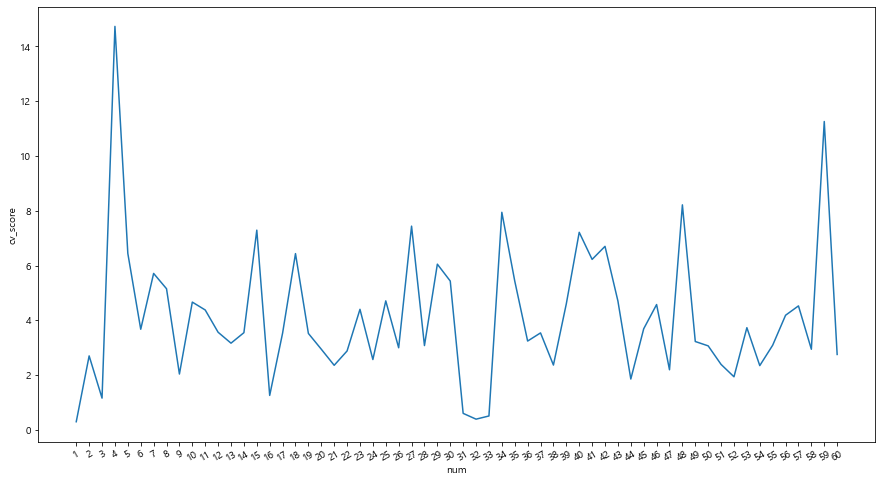

In [50]:
# 건물별 점수 시각화 
plt.figure(figsize = (15, 8))
ax = sns.lineplot(cv_score_agg['num'], cv_score_agg['cv_score'])
ax.set(xticks = cv_score_agg['num'])
plt.xticks(rotation = 30)

# Submission

In [51]:
sub = pd.read_csv('../dacon power use/dataset/sample_submission.csv')
sub

num_date_time  answer
0       1 2020-08-25 00       0
1       1 2020-08-25 01       0
2       1 2020-08-25 02       0
3       1 2020-08-25 03       0
4       1 2020-08-25 04       0
...                 ...     ...
10075  60 2020-08-31 19       0
10076  60 2020-08-31 20       0
10077  60 2020-08-31 21       0
10078  60 2020-08-31 22       0
10079  60 2020-08-31 23       0

[10080 rows x 2 columns]

In [52]:
sub['answer'] = lgb_pred_test
sub

num_date_time       answer
0       1 2020-08-25 00  8692.400063
1       1 2020-08-25 01  8677.733713
2       1 2020-08-25 02  8660.183478
3       1 2020-08-25 03  8644.184693
4       1 2020-08-25 04  8635.107466
...                 ...          ...
10075  60 2020-08-31 19  4019.355809
10076  60 2020-08-31 20  3940.359050
10077  60 2020-08-31 21  3791.339181
10078  60 2020-08-31 22  3569.093343
10079  60 2020-08-31 23  3276.962061

[10080 rows x 2 columns]